In [344]:
import os
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import itertools
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from matplotlib import pyplot
import plotly.graph_objects as go
import gc
import copy
import random
import re
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.io as pio
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tools.eval_measures import rmse
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import datetime

import os
import re

# from tensorflow.keras.layers import LSTM,Dropout,Activation,Dense,BatchNormalization,Input,Bidirectional
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model,Sequential
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_validate
import statsmodels.api as sm
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.cluster import AgglomerativeClustering
from tslearn.metrics import dtw, cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram


from matplotlib import font_manager, rc
rc('font', family='HCR Dotum')


pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 9999)

-----

# 1.  EDA_1

In [144]:
path = 'data' # 데이터 경로

In [203]:
# 훈련데이터
food_waste = pd.read_csv(path+"/01_음식물쓰레기.CSV", encoding='euc-kr') 
korean = pd.read_csv(path+'/02-1_내국인유동인구.CSV', encoding='euc-kr')
resident = pd.read_csv(path+'/03_거주인구.CSV', encoding='euc-kr')
card_spending = pd.read_csv(path+'/04_음식관련 카드소비.csv', encoding='euc-kr')

# 칼럼명 변경
food_waste.columns = ['date','도시','행정동_코드','행정동명','배출거점지역_코드','배출건수','배출량','총_지불금액']
korean.columns = ['date','시간','도시','행정동_코드','행정동명','성별','연령대','거주인구','근무인구','방문인구','거주지역행정구역']
resident.columns = ['year','month','도시','행정동_코드','행정동명','성별','주민등록_거주인구','외국인_거주인구','총_거주인구']
card_spending.columns = ['date','도시','행정동_코드','행정동명','음식_업종_코드_대분류','음식_업종_코드_소분류','결제건수','결제금액']

# 용도지역지구 데이터
city_2020 = pd.read_csv('data/행정동별_용도지역지구_2020.csv', encoding='utf8')
city_2015 = pd.read_csv('data/행정동별_용도지역지구_2015.csv', encoding='utf8')

In [146]:
# 년, 월을 만드는 함수
def make_year_month(df):
    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year

In [205]:
make_year_month(food_waste)
make_year_month(korean)
make_year_month(card_spending)

## 행정동별 일별 음식물 쓰레기 배출량 평균
- 행정동 중 음식물 쓰레기 배출량 집계가 시작된 시기가 다른 행정동이 존재

## 음식물 쓰레기양 merge

In [153]:
merge_data = pd.merge(resident,food_waste.groupby(["행정동명","year","month"])["배출량"].sum(),on=["행정동명","year","month"],how="left")
merge_data = merge_data[~merge_data.isnull().sum(axis=1).astype(bool)] # 2019년 11월부터 측정된 행정동으로 null값이 존재하는 행 제거
dongs = merge_data["행정동명"].unique() # 제주도의 행정동을 담은 리스트
merge_data.head()

,year,month,도시,행정동_코드,행정동명,성별,주민등록_거주인구,외국인_거주인구,총_거주인구,배출량
0,2018,1,제주시,50110590,건입동,남성,5085,146,5231,45646550.0
1,2018,1,제주시,50110590,건입동,여성,4715,82,4797,45646550.0
4,2018,1,서귀포시,50130253,남원읍,남성,9806,428,10234,42437700.0
5,2018,1,서귀포시,50130253,남원읍,여성,9306,200,9506,42437700.0
6,2018,1,제주시,50110660,노형동,남성,26286,821,27107,265018400.0


## 년별 추이

In [154]:
yearly_data = merge_data.groupby("year").sum().join(korean.groupby("year")[["거주인구","근무인구","방문인구"]].sum())
del yearly_data["행정동_코드"]
yearly_data.head()

,month,주민등록_거주인구,외국인_거주인구,총_거주인구,배출량,거주인구,근무인구,방문인구
year,,,,,,,,
2018,5772,7082727,214431,7297158,5.835173e+10,4.428362e+09,5.164793e+08,2.765982e+09
2019,5956,7286211,248575,7534786,5.827841e+10,4.474772e+09,5.198259e+08,2.813975e+09
2020,6396,8022722,288254,8310976,6.448569e+10,4.829459e+09,4.620125e+08,2.588541e+09
2021,1722,4028163,131475,4159638,3.091536e+10,2.599406e+09,2.320741e+08,1.356278e+09


## 거주인구 년별 추이
- 상승하는 추세

<AxesSubplot:xlabel='year', ylabel='총_거주인구'>

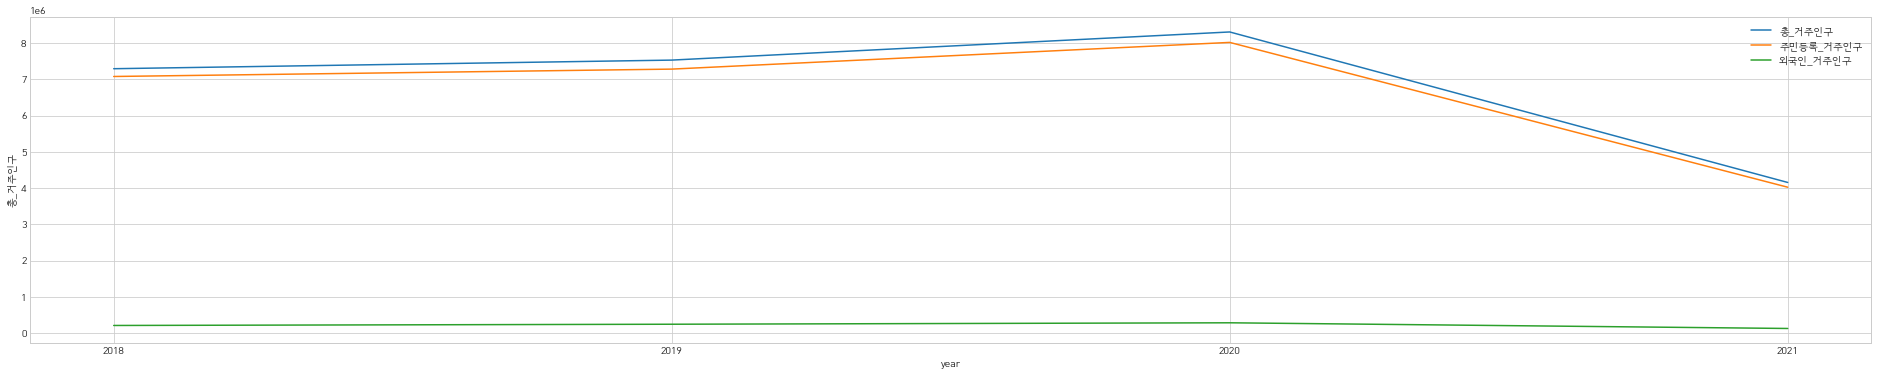

In [155]:
plt.figure(figsize=(33,6))
sns.lineplot(x=yearly_data.index.astype(str), y=yearly_data["총_거주인구"],label="총_거주인구")
sns.lineplot(x=yearly_data.index.astype(str), y=yearly_data["주민등록_거주인구"],label="주민등록_거주인구")
sns.lineplot(x=yearly_data.index.astype(str), y=yearly_data["외국인_거주인구"],label="외국인_거주인구")

## 배출량

In [156]:
# 2019년 11월부터 데이터가 존재하는 행정동과 2018년 1월부터 데이터가 존재하는 행정동 데이터 분리
all_exist = (food_waste["행정동명"]!='조천읍')&(food_waste["행정동명"]!='구좌읍')&(food_waste["행정동명"]!='한림읍')&(food_waste["행정동명"]!='한경면')

all_exist_food_waste = food_waste[all_exist]    # 2018년 1월부터 존재 행정동
later_exist_food_waste = food_waste[~all_exist] # 2019년 11월부터 존재 행정동

In [157]:
yearly_food_waste = all_exist_food_waste.groupby("year")[["배출량"]].sum()

<AxesSubplot:xlabel='year', ylabel='배출량'>

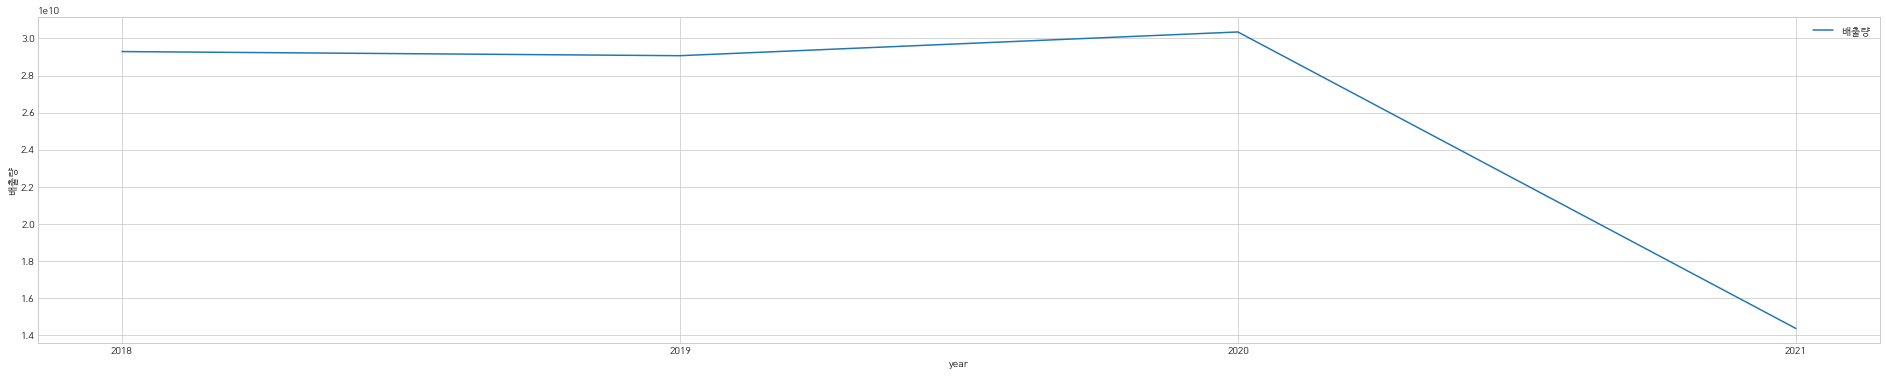

In [158]:
plt.figure(figsize=(33,6))
sns.lineplot(x=yearly_food_waste.index.astype(str), y=yearly_food_waste["배출량"],label="배출량")

## 년별 월별 추이

In [159]:
yearly_monthly_data = merge_data.groupby(["year","month"]).sum().join(korean.groupby(["year","month"])[["거주인구","근무인구","방문인구"]].sum())

In [160]:
monthly_data = merge_data.groupby("month").sum().join(korean.groupby("month")[["거주인구","근무인구","방문인구"]].sum())
del monthly_data["행정동_코드"]
del yearly_monthly_data["행정동_코드"]

In [161]:
# 2018-01~2021-6 까지의 '[년]-[월]'을 담은 리스트
year_months = [f"{i}-{j}" for i,j in merge_data.groupby(["year","month"]).sum().index]

## 거주인구 월별 추이
- 2019년 9월에 거주인구 급격하게 증가
- 거주인구는 월별 증감이 미미

<AxesSubplot:ylabel='총_거주인구'>

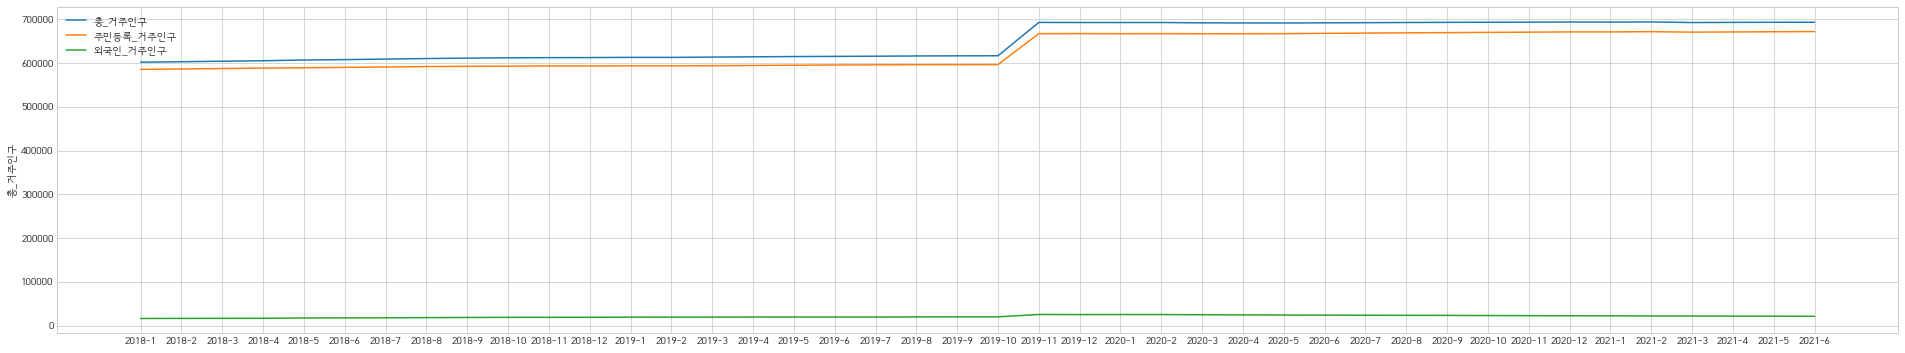

In [162]:
plt.figure(figsize=(33,6))
sns.lineplot(x=year_months, y=yearly_monthly_data["총_거주인구"],label="총_거주인구")
sns.lineplot(x=year_months, y=yearly_monthly_data["주민등록_거주인구"],label="주민등록_거주인구")
sns.lineplot(x=year_months, y=yearly_monthly_data["외국인_거주인구"],label="외국인_거주인구")

## 유동인구 월별 추이
- 유동인구의 경우 월별 증감이 있긴 하지만, 진폭이 배출량에 비해 크지 않음

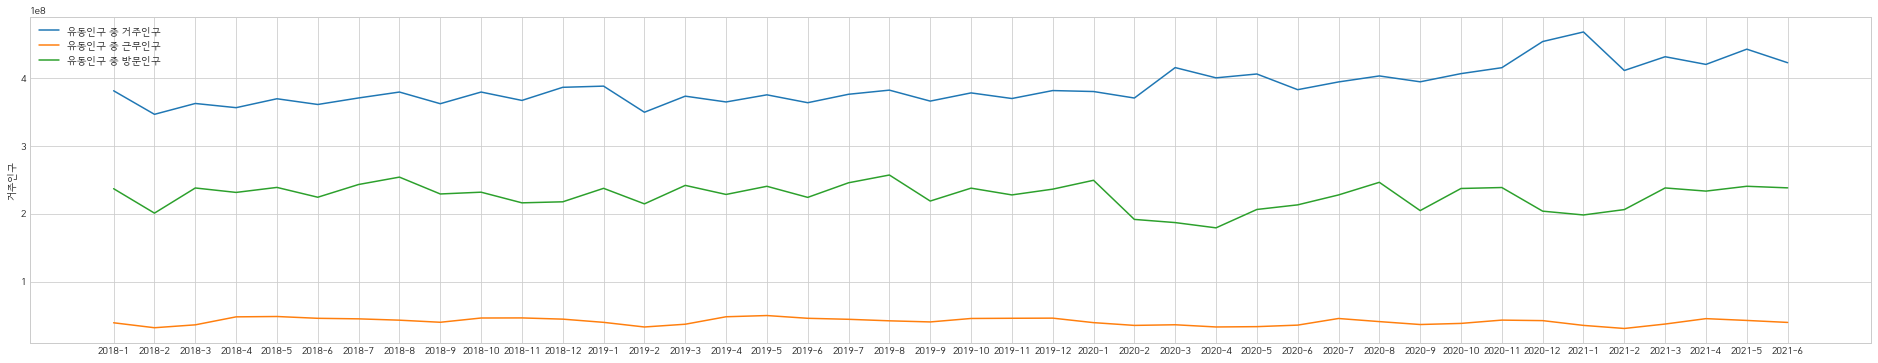

In [163]:
plt.figure(figsize=(33,6))
sns.lineplot(x=year_months, y=yearly_monthly_data["거주인구"],label="유동인구 중 거주인구")
sns.lineplot(x=year_months, y=yearly_monthly_data["근무인구"],label="유동인구 중 근무인구")
sns.lineplot(x=year_months, y=yearly_monthly_data["방문인구"],label="유동인구 중 방문인구")
plt.legend()

## 배출량

In [164]:
yearly_monthly_food_waste = all_exist_food_waste.groupby(["year","month"])[["배출량"]].sum()

<AxesSubplot:ylabel='배출량'>

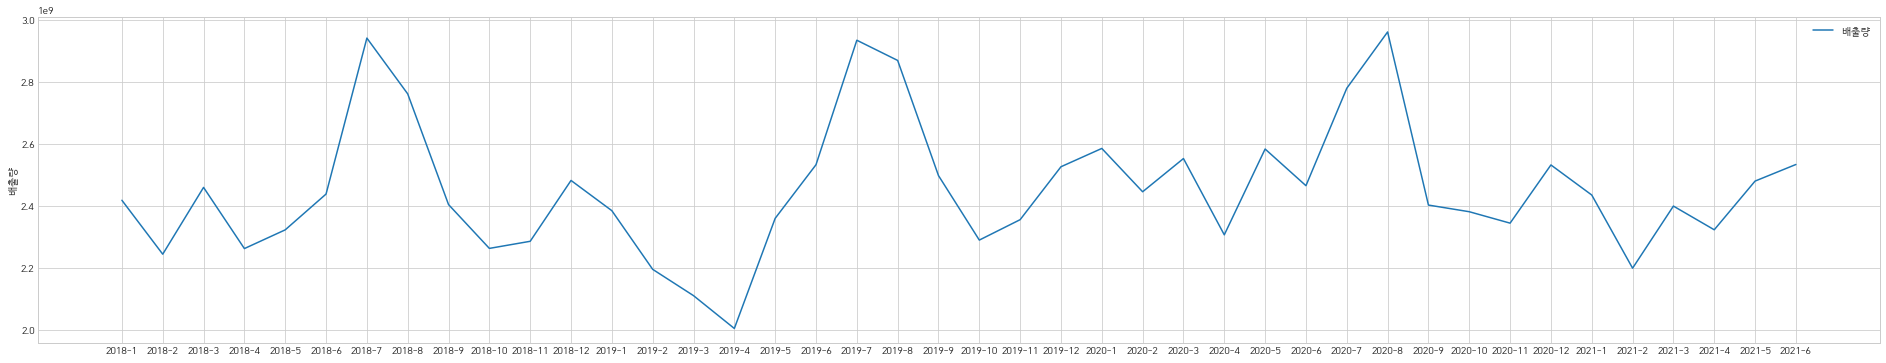

In [165]:
plt.figure(figsize=(33,6))
sns.lineplot(x=year_months, y=yearly_monthly_food_waste["배출량"],label="배출량")

## 거주인구와 배출량
- 주민등록거주인구, 외국인거주인구, 총거주인구 모두 배출량과 상관관계 존재
- 특히 주민등록거주인구, 총거주인구가 배출량과 더 많은 상관관계 존재

In [166]:
merge_data.groupby(["행정동명","year","month"]).sum()

행정동_코드  주민등록_거주인구  외국인_거주인구  총_거주인구         배출량
행정동명 year month                                                    
건입동  2018 1      100221180       9800       228   10028  91293100.0
          2      100221180       9814       224   10038  85907100.0
          3      100221180       9783       222   10005  92844900.0
          4      100221180       9788       229   10017  84877400.0
          5      100221180       9800       238   10038  89786600.0
...                    ...        ...       ...     ...         ...
효돈동  2021 2      100261100       5289        65    5354  52256800.0
          3      100261100       5262        61    5323  53690800.0
          4      100261100       5267        59    5326  50400400.0
          5      100261100       5266        60    5326  43449700.0
          6      100261100       5257        57    5314  55108200.0

[1634 rows x 5 columns]

In [167]:
merge_data.groupby(["행정동명","year","month"]).sum().corr()

,행정동_코드,주민등록_거주인구,외국인_거주인구,총_거주인구,배출량
행정동_코드,1.000000,-0.373073,-0.054348,-0.364496,-0.337958
주민등록_거주인구,-0.373073,1.000000,0.612625,0.999289,0.888455
외국인_거주인구,-0.054348,0.612625,1.000000,0.641997,0.496605
총_거주인구,-0.364496,0.999289,0.641997,1.000000,0.885548
배출량,-0.337958,0.888455,0.496605,0.885548,1.000000


## 유동인구와 배출량
- 행정동별 월별 총 거주인구, 근무인구, 방문인구와 총 배출량의 상관계수는 각각 0.87, 0.80, 0.73으로 상관관계가 높음

In [168]:
# 월별 각 행정동의 총 거주인구, 근무인구, 방문인구, 배출량
monthly_food_waste_people = food_waste.groupby(["행정동명","year","month"])[["배출량"]].sum().join(korean.groupby(["행정동명","year","month"])[["거주인구","근무인구","방문인구"]].sum())
monthly_food_waste_people

배출량          거주인구         근무인구          방문인구
행정동명 year month                                                   
건입동  2018 1      45646550  4.935983e+06  703935.3180  4.938897e+06
          2      42953550  4.564513e+06  581624.8367  4.444065e+06
          3      46422450  4.654124e+06  707207.2324  4.796903e+06
          4      42438700  4.426399e+06  742007.4365  4.842401e+06
          5      44893300  4.546525e+06  758835.6074  5.035772e+06
...                   ...           ...          ...           ...
효돈동  2021 2      26128400  2.733611e+06  173348.3131  1.214627e+06
          3      26845400  2.842302e+06  151194.6666  1.162818e+06
          4      25200200  2.734716e+06  171591.1849  1.187787e+06
          5      21724850  2.911277e+06  153324.9017  1.256721e+06
          6      27554100  2.793702e+06  145978.7332  1.206070e+06

[1666 rows x 4 columns]

In [169]:
# 칼럼간의 상관관계
monthly_food_waste_people.corr()

,배출량,거주인구,근무인구,방문인구
배출량,1.000000,0.873987,0.796384,0.726660
거주인구,0.873987,1.000000,0.907639,0.884228
근무인구,0.796384,0.907639,1.000000,0.902026
방문인구,0.726660,0.884228,0.902026,1.000000


## 성별과 배출량
- 여성이 남성에 비해 상관관계가 높음

In [170]:
del merge_data["행정동_코드"]

female = merge_data.groupby(["year","month","행정동명","성별"]).sum().loc[:,:,:,"여성"]

Text(0.5, 0, '여성 거주인구')

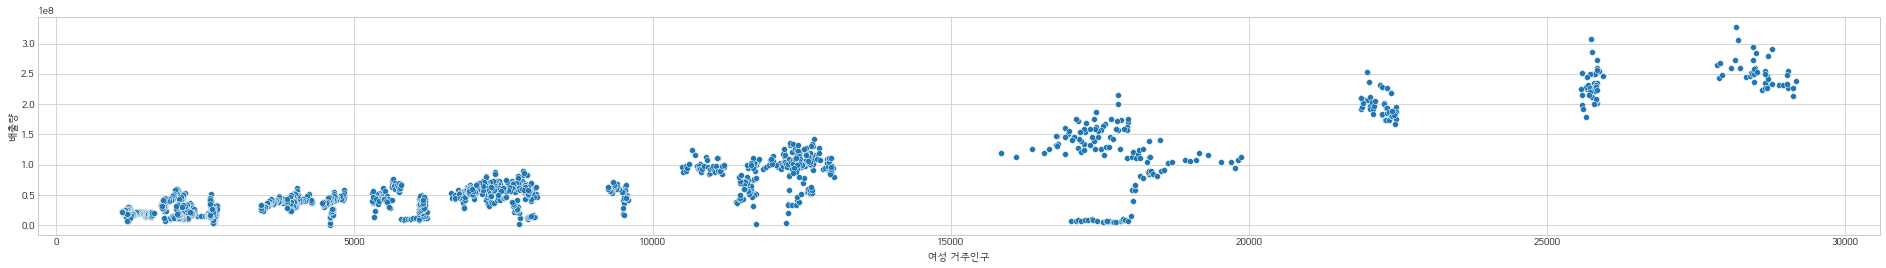

In [171]:
plt.figure(figsize=(33,4))
sns.scatterplot(x="총_거주인구",y="배출량",data=female)
plt.xlabel("여성 거주인구")

In [172]:
female.corr()

,주민등록_거주인구,외국인_거주인구,총_거주인구,배출량
주민등록_거주인구,1.000000,0.710791,0.999587,0.897534
외국인_거주인구,0.710791,1.000000,0.730718,0.610066
총_거주인구,0.999587,0.730718,1.000000,0.896023
배출량,0.897534,0.610066,0.896023,1.000000


In [173]:
male = merge_data.groupby(["year","month","행정동명","성별"]).sum().loc[:,:,:,"남성"]

Text(0.5, 0, '남성 거주인구')

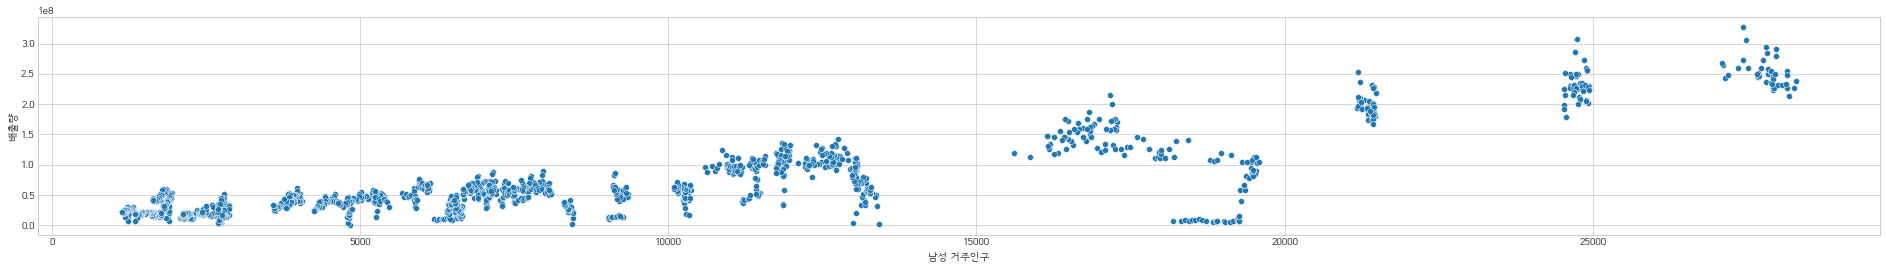

In [174]:
plt.figure(figsize=(33,4))
sns.scatterplot(x="총_거주인구",y="배출량",data=male)
plt.xlabel("남성 거주인구")

In [175]:
male.corr()

,주민등록_거주인구,외국인_거주인구,총_거주인구,배출량
주민등록_거주인구,1.000000,0.522995,0.998835,0.878388
외국인_거주인구,0.522995,1.000000,0.563515,0.395591
총_거주인구,0.998835,0.563515,1.000000,0.873753
배출량,0.878388,0.395591,0.873753,1.000000


## 월별 총 거주인구 대비 배출량

In [176]:
monthly_rate = merge_data.groupby(["year","month"]).sum()
monthly_rate["거주인구 대비 배출량"]=food_waste.groupby(["year","month"]).sum()["배출량"]/merge_data.groupby(["year","month"])["총_거주인구"].sum()

<AxesSubplot:ylabel='거주인구 대비 배출량'>

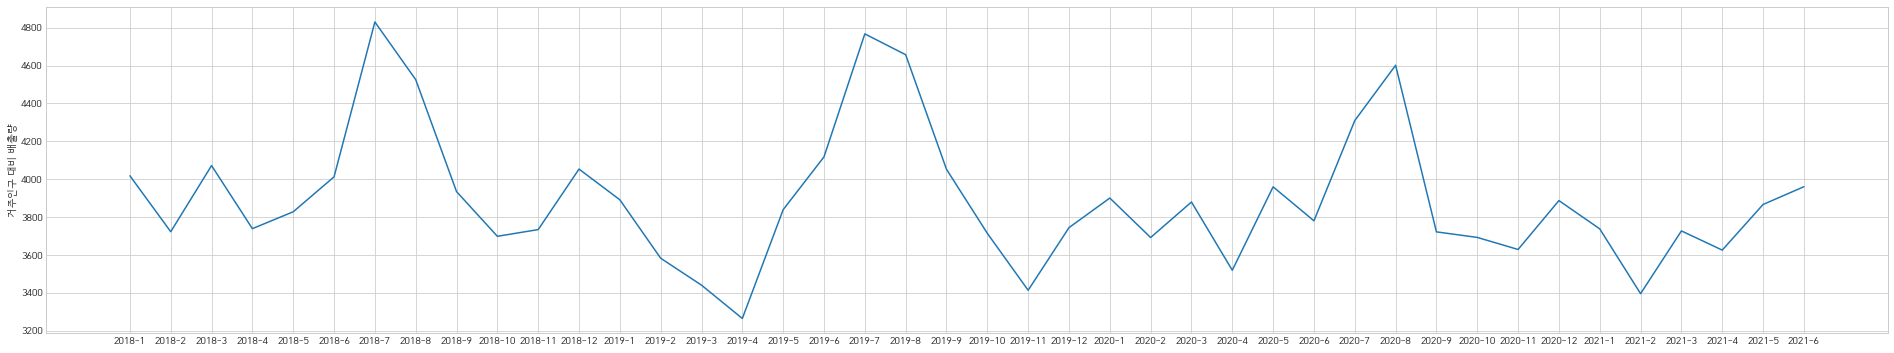

In [177]:
plt.figure(figsize=(33,6))
sns.lineplot(x=year_months, y=monthly_rate["거주인구 대비 배출량"])

## 총 거주인구 대비 음식물 쓰레기 배출량
- 총 거주인구 대비 음식물 쓰레기 배출량이 많은 지역 : ['중앙동', '정방동', '천지동', '일도1동', '이도1동']

In [178]:
food_waste_per_person = (merge_data.groupby("행정동명").sum()["배출량"]/merge_data.groupby("행정동명").sum()["총_거주인구"]).sort_values(ascending=False)

<AxesSubplot:xlabel='행정동명'>

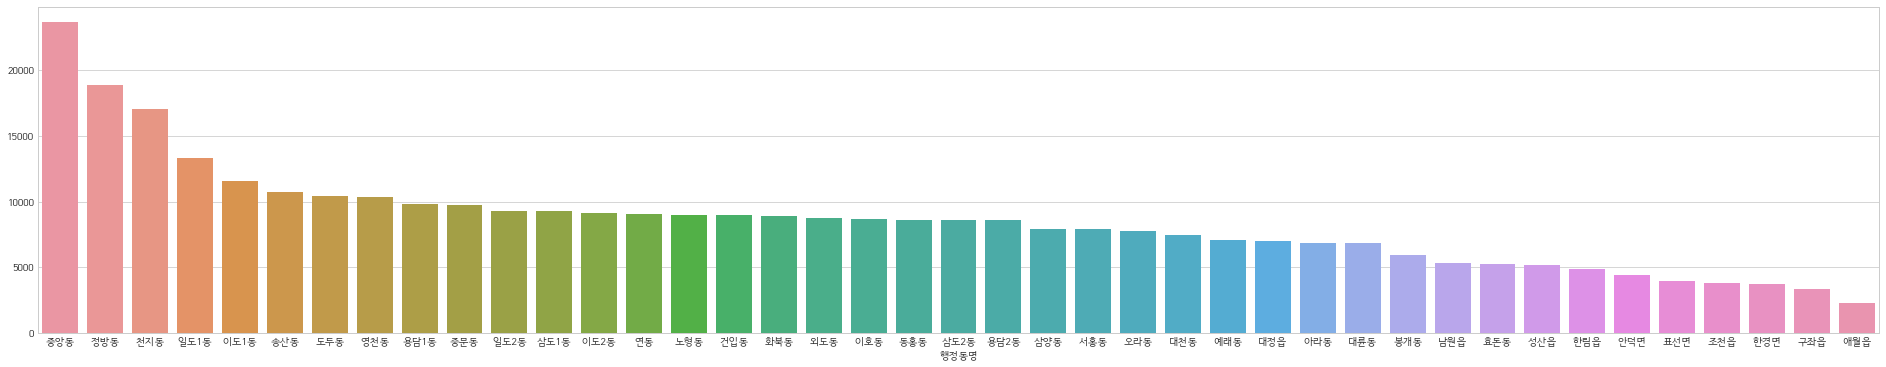

In [179]:
plt.figure(figsize=(33,6))
sns.barplot(x=food_waste_per_person.index, y=food_waste_per_person.values)

## 성별과 총 거주인구 대비 음식물 쓰레기 배출량
- 남성 대비 여성 거주인구 비율과 거주인구 대비 배출량의 상관관계
    - 남성 대비 여성 거주인구와 배출량은 양의 상관관계
    - 즉, 거주인구 중 여성 인구가 차지하는 비율이 높아지면 거주인구 대비 배출량도 높아진다.

In [180]:
monthly_sex_rate = (merge_data.groupby(["year","month","행정동명","성별"]).sum().loc[:,:,:,"여성"]/merge_data.groupby(["year","month","행정동명","성별"]).sum().loc[:,:,:,"남성"])[["총_거주인구"]]
monthly_sex_rate["거주인구 대비 배출량"]=food_waste.groupby(["year","month","행정동명"]).sum()["배출량"]/merge_data.groupby(["year","month","행정동명"])["총_거주인구"].sum()
monthly_sex_rate.rename({"총_거주인구":"남성인구 대비 여성인구"},inplace=True, axis=1)

In [181]:
monthly_sex_rate

남성인구 대비 여성인구  거주인구 대비 배출량
year month 행정동명 성별                           
2018 1     건입동  남성           NaN  4551.909653
                여성           NaN  4551.909653
           남원읍  남성           NaN  2149.832827
                여성           NaN  2149.832827
           노형동  남성           NaN  4822.198770
...                          ...          ...
2021 6     한림읍  여성           NaN  3382.674761
           화북동  남성           NaN  4496.550954
                여성           NaN  4496.550954
           효돈동  남성           NaN  5185.190064
                여성           NaN  5185.190064

[3268 rows x 2 columns]

In [182]:
monthly_sex_rate.corr()

,남성인구 대비 여성인구,거주인구 대비 배출량
남성인구 대비 여성인구,NaN,NaN
거주인구 대비 배출량,NaN,1.0


## 거주인구 대비 배출량 top5 행정동만 확인

In [183]:
top5 = list(food_waste_per_person.index[:5])
top5

['중앙동', '정방동', '천지동', '일도1동', '이도1동']

In [184]:
# 행정동별 성별 거주인구 비율
sex_rate = resident.groupby(["행정동명","성별"])["총_거주인구"].sum()/resident.groupby("행정동명")["총_거주인구"].sum()

In [185]:
sex_rate.loc[top5]

행정동명  성별
중앙동   남성    0.476096
      여성    0.523904
정방동   남성    0.507895
      여성    0.492105
천지동   남성    0.508004
      여성    0.491996
일도1동  남성    0.526937
      여성    0.473063
이도1동  남성    0.494178
      여성    0.505822
Name: 총_거주인구, dtype: float64

In [186]:
# 거주인구 대비 배출량이 높은 지역들 특성

print("거주인구 대비 배출량이 높은 top5의 성별 비율 평균")
display(sex_rate.loc[top5].groupby("성별").mean())
print("------------------------------------------")
print("거주인구 대비 배출량이 높지 않은 지역의 성별 비율 평균")
display(sex_rate.loc[set(dongs)-set(top5)].groupby("성별").mean())

거주인구 대비 배출량이 높은 top5의 성별 비율 평균


성별
남성    0.502622
여성    0.497378
Name: 총_거주인구, dtype: float64

------------------------------------------
거주인구 대비 배출량이 높지 않은 지역의 성별 비율 평균


성별
남성    0.509846
여성    0.490154
Name: 총_거주인구, dtype: float64

## 내국인, 외국인 비율과 총 거주인구 대비 배출량
- 내국인, 외국인 비율은 총 거주인구 대비 배출량과 상관관계가 높지 않음

In [187]:
monthly_foreigner_rate = merge_data.groupby(["year","month","행정동명"]).sum()
monthly_foreigner_rate = pd.DataFrame(monthly_foreigner_rate["외국인_거주인구"]/monthly_foreigner_rate["주민등록_거주인구"])
monthly_foreigner_rate["거주인구 대비 배출량"]=food_waste.groupby(["year","month","행정동명"]).sum()["배출량"]/merge_data.groupby(["year","month","행정동명"])["총_거주인구"].sum()
monthly_foreigner_rate.rename({0:"내국인 대비 외국인"},inplace=True, axis=1)
monthly_foreigner_rate["배출량"] = yearly_monthly_data["배출량"]

In [188]:
monthly_foreigner_rate.corr()

,내국인 대비 외국인,거주인구 대비 배출량,배출량
내국인 대비 외국인,1.000000,-0.073651,0.020866
거주인구 대비 배출량,-0.073651,1.000000,0.147010
배출량,0.020866,0.147010,1.000000


## 행정동별 외국인 비율 top 5

In [189]:
day_mean_food_waste = food_waste.groupby(["date","행정동명"]).sum().groupby("행정동명")["배출량"].mean()
day_mean_food_waste.drop("알수없음", axis=0, inplace=True)

# 행정동별 외국인 비율
foreigner_rate = merge_data.groupby(["행정동명"])["외국인_거주인구"].sum()/merge_data.groupby("행정동명")["총_거주인구"].sum()

In [190]:
print("거주인구 대비 배출량이 높은 top5의 외국인 비율 평균")
print("%.4f"%foreigner_rate.loc[top5].mean())
print("--------------------------------")
print("그 외 지역의 외국인 비율 평균")
print("%.4f"%foreigner_rate.loc[set(dongs)-set(top5)].mean())

거주인구 대비 배출량이 높은 top5의 외국인 비율 평균
0.0303
--------------------------------
그 외 지역의 외국인 비율 평균
0.0355


## 읍/면/동별 배출량
- 읍/면/동의 음식물 쓰레기 배출량 평균
    - 동, 읍, 면 순 대로 유동인구 대비 음식물 쓰레기 배출량 평균이 높음

In [191]:
# 총 거주인구 대비 배출량 df에 해당 행정동이 읍/면/동 인지를 알려주는 칼럼 추가
food_waste_per_person = pd.DataFrame(food_waste_per_person).reset_index()
food_waste_per_person["읍/면/동"] = food_waste_per_person["행정동명"].apply(lambda x: x[-1])
food_waste_per_person.rename({0:"총 거주인구 대비 배출량"},inplace=True, axis=1)

In [192]:
food_waste_per_person.groupby("읍/면/동").mean()

,총 거주인구 대비 배출량
읍/면/동,
동,9842.798542
면,4005.985107
읍,4545.620655


## 유동인구 인구비율별 총 거주인구 대비 배출량
- 거주인구 대비 배출량이 높은 지역은 유동인구 중 타지에서 방문하는 인구가 해당 지역에서 방문하는 인구보다 많음
- 실제로 유동인구 중 타지에서 방문하는 인구가 해당 지역에서 방문하는 인구보다 많은 지역이 거주인구 대비 배출량과 유동인구 대비 배출량이 높음

In [193]:
# 월별 각 행정동의 총 거주인구, 근무인구, 방문인구, 배출량
food_waste_people = food_waste.groupby("행정동명")[["배출량"]].sum().join(korean.groupby("행정동명")[["거주인구","근무인구","방문인구"]].sum())
food_waste_people.drop("알수없음",axis=0,inplace=True)

In [194]:
# 유동인구를 거주인구, 외지인구로 구분
food_waste_people["외지인구"]=food_waste_people["근무인구"]+food_waste_people["방문인구"]

# 거주인구에 비해 외지인구가 어느 정도 인가
food_waste_people["외지인구/거주인구"]=(food_waste_people["외지인구"]/food_waste_people["거주인구"])

# 1분위수, 3분위수를 기준으로 외지인구가 더 많은 지역, 비슷한 지역, 거주인구가 더 많은 지역으로 구분
character_dong = []
for x in food_waste_people["외지인구/거주인구"].values:
    if x>=food_waste_people["외지인구/거주인구"].quantile(0.75):
        character_dong.append("외지인구가 더 많음")
    elif x>=food_waste_people["외지인구/거주인구"].quantile(0.25):
        character_dong.append("인구 비율 비슷함")
    else:
        character_dong.append("거주인구가 더 많음")
food_waste_people["인구비율"] = character_dong

In [195]:
food_waste_people.groupby("인구비율").count() # 나뉜 현황

,배출량,거주인구,근무인구,방문인구,외지인구,외지인구/거주인구
인구비율,,,,,,
거주인구가 더 많음,10,10,10,10,10,10
외지인구가 더 많음,11,11,11,11,11,11
인구 비율 비슷함,20,20,20,20,20,20


In [196]:
food_waste_people.loc[top5][["인구비율"]]

,인구비율
행정동명,
중앙동,외지인구가 더 많음
정방동,외지인구가 더 많음
천지동,외지인구가 더 많음
일도1동,외지인구가 더 많음
이도1동,외지인구가 더 많음


In [197]:
# 유동인구 대비 배출량 칼럼 추가
food_waste_people["유동인구 대비 배출량"] = food_waste_people["배출량"]/(food_waste_people["거주인구"]+food_waste_people["외지인구"])

# 거주인구 대비 배출량 칼럼 추가
food_waste_per_person.index = food_waste_per_person["행정동명"]
food_waste_people = food_waste_people.join(food_waste_per_person)

In [198]:
food_waste_people.groupby("인구비율").mean()

,배출량,거주인구,근무인구,방문인구,외지인구,외지인구/거주인구,유동인구 대비 배출량,총 거주인구 대비 배출량
인구비율,,,,,,,,
거주인구가 더 많음,4.494113e+09,6.737693e+08,6.048501e+07,2.584219e+08,3.189069e+08,0.470505,4.733669,7637.283529
외지인구가 더 많음,1.303325e+09,1.038276e+08,2.154263e+07,1.507437e+08,1.722863e+08,2.017368,5.947923,12314.217122
인구 비율 비슷함,2.336894e+09,4.189412e+08,4.420898e+07,2.606616e+08,3.048705e+08,0.791744,3.841703,6856.741554


In [263]:
monthly_data = food_waste.groupby(["year","month","행정동명"]).sum().join(resident.groupby(["year","month","행정동명"]).sum())
monthly_data["거주인구 대비 배출량"] = monthly_data["배출량"]/monthly_data["총_거주인구"]

In [264]:
# 월별 행정동별 각 음식 업종 결제금액/건수
for food in card_spending["음식_업종_코드_소분류"].unique():
    sub_data = card_spending.groupby(["year","month","행정동명","음식_업종_코드_소분류"]).sum().loc[:,:,:,food]
    sub_data.columns = [f"{food}_결제건수",f"{food}결제금액"]
    monthly_data = monthly_data.join(sub_data)

In [289]:
## 강수량 및 카드 소비 등 종합 피벗 데이터
path = 'data/' # 데이터 경로
train_with_x = pd.read_excel(path+"훈련데이터.xlsx")

In [266]:
# 월별 행정동별 거주인구 대비 각 음식 업종 결제금액/건수
monthly_data = monthly_data.join(monthly_data.iloc[:,8:]/(monthly_data[["총_거주인구"]].values),rsuffix="_거주인구 대비")
# 관광객 수
monthly_data["총_관광객"] = train_with_x["총_관광객"].values 

## 시간대별 유동인구와 거주인구 대비 배출량
- 시간대별 유동인구 조사
    - 유동인구 중 거주인구는 새벽(12~8)시 가량이 가장 많음
    - 유동인구 중 근무인구는 오전,오후 시간대(10~18)(업무시간대)가 가장 많음
    - 유동인구 중 방문인구는 오후, 저녁 시간대(12~20)가 가장 많음
    - 시간대별 유동인구와 거주인구 대비 배출량은 모든 시간에서 음의 상관관계를 보임

## 시간대별 유동인구

In [267]:
food_waste_per_person = (merge_data.groupby("행정동명").sum()["배출량"]/merge_data.groupby("행정동명").sum()["총_거주인구"]).sort_values(ascending=False)
hourly_korean = korean.groupby("시간")[["거주인구","근무인구","방문인구"]].mean() # 유동인구별 시간대 인구

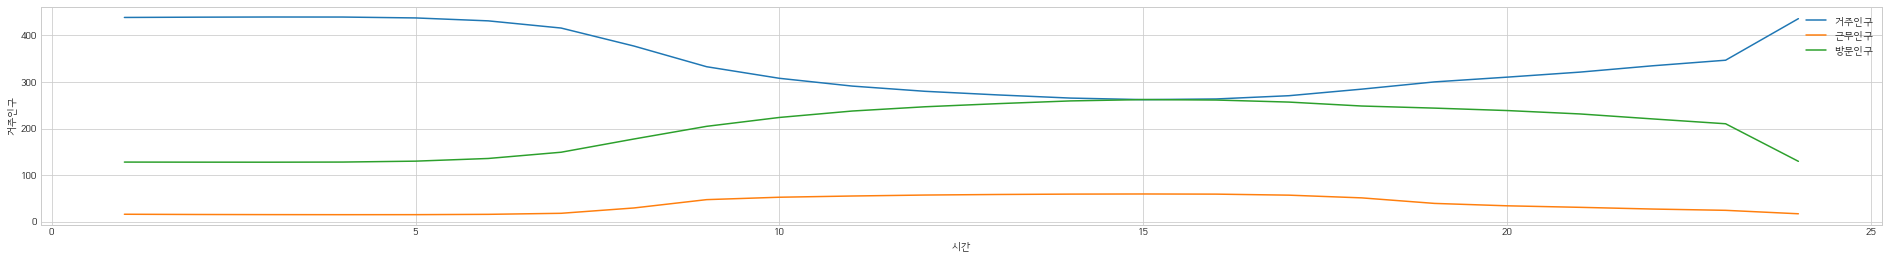

In [268]:
# 유동인구별 시간대 인구
plt.figure(figsize=(33,4))
for col in hourly_korean.columns:
    sns.lineplot(x=hourly_korean.index, y=hourly_korean[col], label=col)
plt.legend()

## 거주인구 대비 각 음식 업종 결제금액/건수 와 거주인구 대비 배출량
- 월별 행정동별 각 음식 업종 결제금액/건수 와 거주인구 대비 배출량을 살핌
- 거주인구 대비 농축수산물, 마트/슈퍼마켓 결제 금액/건수가 많을 수록 거주인구 대비 배출량과 양의 상관관계가 강함

In [292]:
monthly_data = train_with_x.groupby(["year","month","행정동명"]).sum()

In [294]:
monthly_data.corr()[["거주인구 대비 배출량"]].iloc[30:].sort_values("거주인구 대비 배출량",ascending=False)

,거주인구 대비 배출량
거주인구 대비 배출량,1.000000
마트/슈퍼마켓결제금액_거주인구 대비,0.606310
농축수산물결제금액_거주인구 대비,0.577736
마트/슈퍼마켓_결제건수_거주인구 대비,0.453182
농축수산물_결제건수_거주인구 대비,0.413946
아시아음식결제금액_거주인구 대비,0.340915
한식결제금액_거주인구 대비,0.334430
아시아음식_결제건수_거주인구 대비,0.310441
패스트푸드_결제건수_거주인구 대비,0.299181
한식_결제건수_거주인구 대비,0.273663


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 [Text(0, 0, '거주인구 대비 배출량'),
  Text(1, 0, '마트/슈퍼마켓결제금액_거주인구 대비'),
  Text(2, 0, '농축수산물결제금액_거주인구 대비'),
  Text(3, 0, '마트/슈퍼마켓_결제건수_거주인구 대비'),
  Text(4, 0, '농축수산물_결제건수_거주인구 대비'),
  Text(5, 0, '아시아음식결제금액_거주인구 대비'),
  Text(6, 0, '한식결제금액_거주인구 대비'),
  Text(7, 0, '아시아음식_결제건수_거주인구 대비'),
  Text(8, 0, '패스트푸드_결제건수_거주인구 대비'),
  Text(9, 0, '한식_결제건수_거주인구 대비'),
  Text(10, 0, '패스트푸드결제금액_거주인구 대비'),
  Text(11, 0, '간식_결제건수_거주인구 대비'),
  Text(12, 0, '주점및주류판매_결제건수_거주인구 대비'),
  Text(13, 0, '간식결제금액_거주인구 대비'),
  Text(14, 0, '주점및주류판매결제금액_거주인구 대비'),
  Text(15, 0, '양식결제금액_거주인구 대비'),
  Text(16, 0, '양식_결제건수_거주인구 대비'),
  Text(17, 0, '부페_결제건수_거주인구 대비'),
  Text(18, 0, '부페결제금액_거주인구 대비'),
  Text(19, 0, '배달_결제건수_거주인구 대비'),
  Text(20, 0, '배달결제금액_거주인구 대비'),
  Text(21, 0, '배출량'),
  Text(22, 0, '식품결제금액_거주인구 대비'),
  T

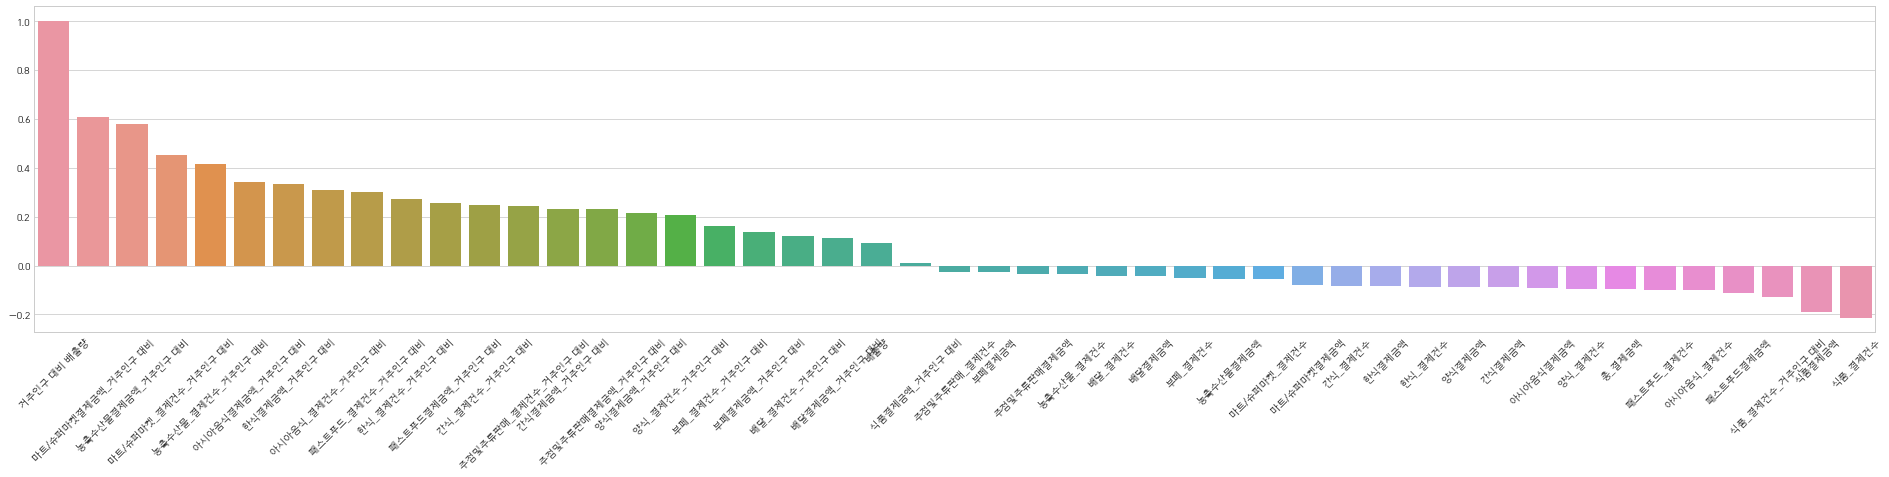

In [295]:
plt.figure(figsize=(33,6))
sns.barplot(x=monthly_data.corr()[["거주인구 대비 배출량"]].iloc[30:].sort_values("거주인구 대비 배출량",ascending=False).index, y=monthly_data.corr()[["거주인구 대비 배출량"]].iloc[30:].sort_values("거주인구 대비 배출량",ascending=False).values.flatten())
plt.xticks(rotation=45)

In [296]:
tmp = monthly_data.groupby(["year","month"]).mean() # 월별 평균
monthly_mean = tmp[["마트/슈퍼마켓결제금액","농축수산물결제금액"]]/(tmp[["총_거주인구"]].values)
monthly_mean["거주인구 대비 배출량"] = tmp["배출량"]/tmp["총_거주인구"]
monthly_mean.rename({"마트/슈퍼마켓결제금액":"마트/슈퍼마켓결제금액_거주인구 대비","농축수산물결제금액":"농축수산물결제금액_거주인구 대비"}, axis=1, inplace=True)
monthly_mean.head()

마트/슈퍼마켓결제금액_거주인구 대비  농축수산물결제금액_거주인구 대비  거주인구 대비 배출량
year   month                                                     
2018.0 1.0           68048.181119       10094.595316  4019.032479
       2.0           65584.575225       12522.995160  3722.990308
       3.0           67080.678902        9923.026519  4073.357711
       4.0           67170.885629       10056.343052  3738.339768
       5.0           72319.667232       11076.515549  3828.481524

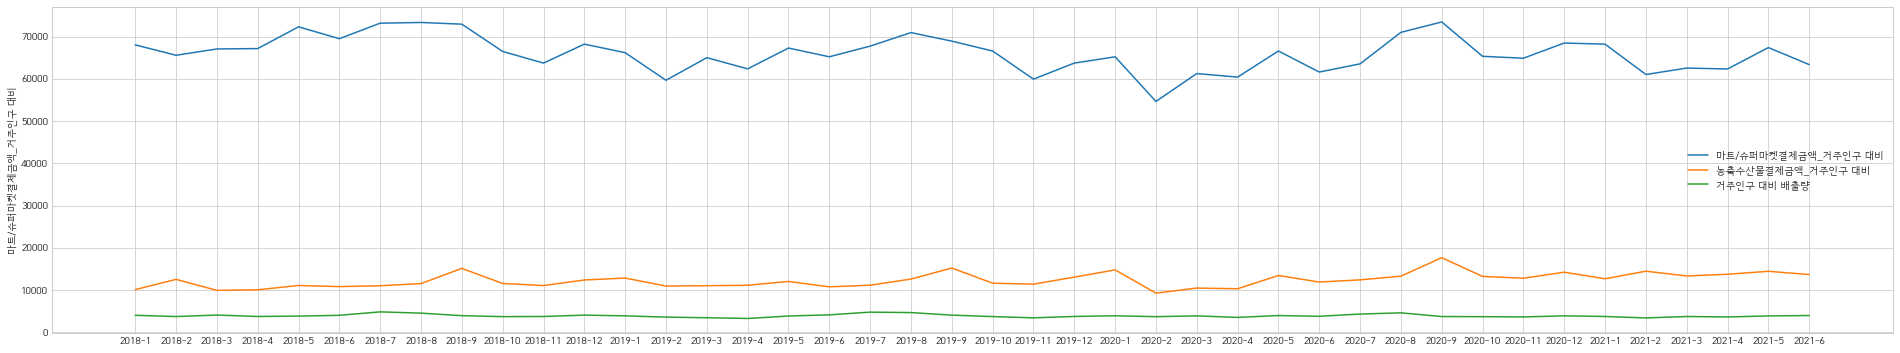

In [297]:
plt.figure(figsize=(33,6))
for col in monthly_mean.columns:
    sns.lineplot(x=year_months, y=monthly_mean[col], label=col)
plt.legend()

## 코로나 이전과 이후 거주인구 대비 각 음식 유형 결제금액/건수와 거주인구 대비 배출량
- 배달 결제 건수 및 결제 금액이 급증(2018,2019보다 2020,2021의 결제 건수 및 결제 금액 약 4배 증가)하고 있기 때문에, 가정용 음식물 쓰레기 양에 배달 음식이 차지하는 비중 또한 늘었을 것임.

<AxesSubplot:ylabel='배달결제금액_거주인구 대비'>

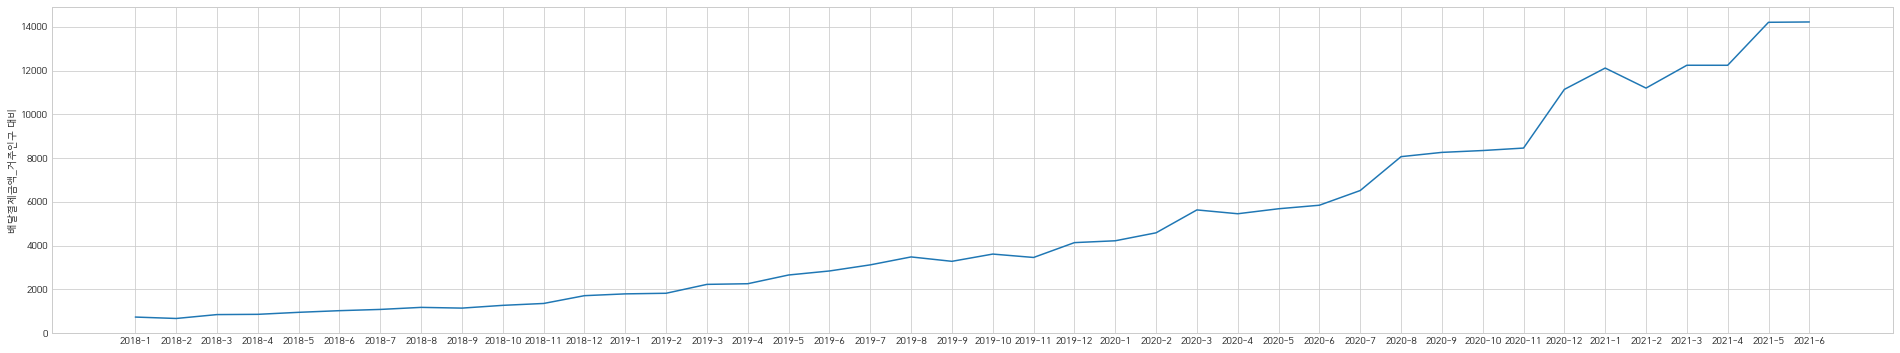

In [341]:
plt.figure(figsize=(33,6))
sns.lineplot(x=year_months, y="배달결제금액_거주인구 대비", data=monthly_data.groupby(["year","month"]).mean())

<AxesSubplot:ylabel='배달_결제건수_거주인구 대비'>

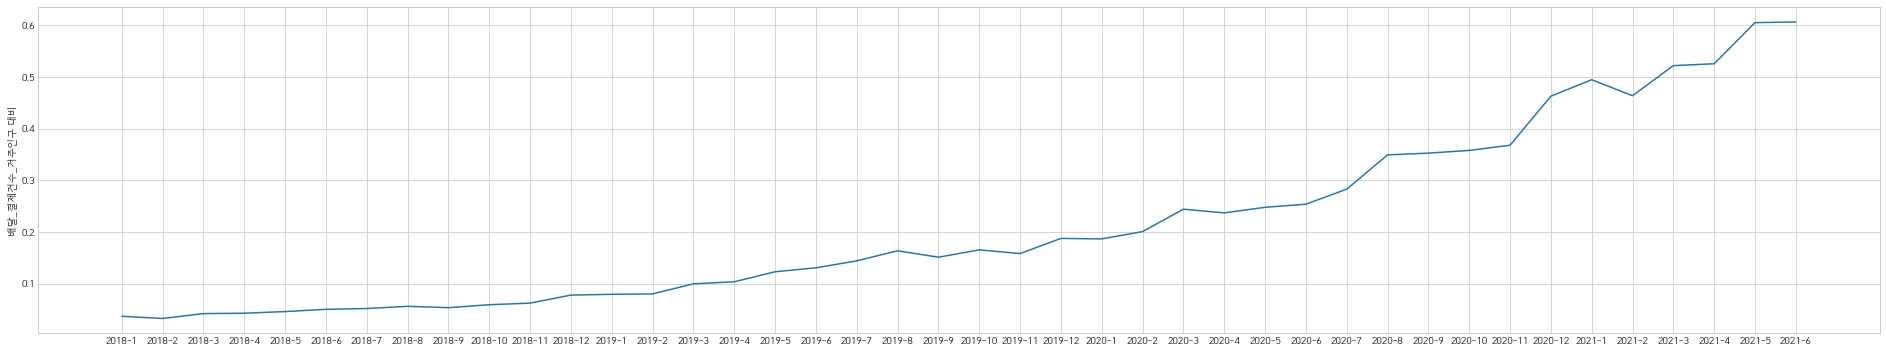

In [342]:
plt.figure(figsize=(33,6))
sns.lineplot(x=year_months, y="배달_결제건수_거주인구 대비", data=monthly_data.groupby(["year","month"]).mean())

-----------------

## [용도지역지구] (외부데이터)

## EDA

In [300]:
# 행정동별 용도지역 개수

city_count_2015 = city_2015.groupby(["행정동명","용도지역"]).count().reset_index()
city_count_2020 = city_2020.groupby(["행정동명","용도지역"]).count().reset_index()

In [301]:
# index 행정동명으로 설정

city_count_2015.index = city_count_2015["행정동명"]
city_count_2020.index = city_count_2020["행정동명"]

In [302]:
# 행정동별 용도지역 개수 percent

city_count_2015["percent"] = city_count_2015["용도지역코드"]/city_2015.groupby("행정동명").count()["용도지역코드"]
city_count_2020["percent"] = city_count_2020["용도지역코드"]/city_2020.groupby("행정동명").count()["용도지역코드"]

In [303]:
city_count_2015.head()

,행정동명,용도지역,date,용도지역코드,percent
행정동명,,,,,
건입동,건입동,도시지역,3,3,1.000000
구좌읍,구좌읍,관리지역,199,199,0.629747
구좌읍,구좌읍,농림지역,7,7,0.022152
구좌읍,구좌읍,도시지역,46,46,0.145570
구좌읍,구좌읍,자연환경보전지역,64,64,0.202532


## 주 용도지역별 일별 배출량 평균
- 각 행정동별 주 용도지역을 구하고, 주 용도지역별 일별 배출량 평균
    - 주 용도지역 : 각 행정동이 갖는 용도지역 중 가장 많은 개수의 용도지역
- 결과 : 주 용도지역이 '도시지역' 인 지역이 '관리지역'인 지역보다 일별 배출량 평균이 높음

In [305]:
# 2015년 행정동별 가장 많은 개수의 용도지역
dong_usage_2015 = {}
for i in city_count_2015["행정동명"].unique():
    dong_usage_2015[i] = city_count_2015[city_count_2015["행정동명"]==i].sort_values(ascending=False,by="percent")["용도지역"][0]

# 2020년 행정동별 가장 많은 개수의 용도지역
dong_usage_2020 = {}
for i in city_count_2020["행정동명"].unique():
    dong_usage_2020[i] = city_count_2020[city_count_2020["행정동명"]==i].sort_values(ascending=False,by="percent")["용도지역"][0]

In [306]:
daily_waste = food_waste.groupby(["행정동명","date"]).sum().groupby("행정동명").mean().reset_index() # 행정동별 일별 평균 배출량
daily_waste["usage"] = daily_waste["행정동명"].apply(lambda x: dong_usage_2015[x] if x in dong_usage_2015 else np.nan) # 행정동별 top1 용도지역

In [307]:
daily_waste.groupby("usage")["배출량"].mean()

usage
관리지역    1.364259e+06
도시지역    2.420443e+06
Name: 배출량, dtype: float64

In [308]:
daily_waste.groupby("usage")["배출량"].median()

usage
관리지역    1.376390e+06
도시지역    1.637142e+06
Name: 배출량, dtype: float64

## 주 용도지역이 변화한 지역
- 한림읍이 관리지역에서 도시지역으로 주 용도지역이 변화
    - 2015년 주 용도지역 : 관리지역
    - 2020년 주 용도지역 : 도시지역
- 결과 : 한림읍 2019년 11월,12월 일별 배출량 평균에 비해 2020년 11,12월 일별 배출량 평균 약 3.7배 증가

In [309]:
# 2020년 행정동별 가장 많은 개수의 용도지역
dong_usage = {}

for i in city_count_2015["행정동명"].unique():
    dong_usage[i] = [city_count_2015[city_count_2015["행정동명"]==i].sort_values(ascending=False,by="percent")["용도지역"][0]]

for i in city_count_2020["행정동명"].unique():
    dong_usage[i].append(city_count_2020[city_count_2020["행정동명"]==i].sort_values(ascending=False,by="percent")["용도지역"][0])

In [310]:
# 2019 한림읍 일별 배출량 평균
food_waste[(food_waste["행정동명"]=="한림읍")&(food_waste["year"]==2019)].groupby("date").sum().mean()

배출건수         157.107143
배출량       603092.857143
총_지불금액     18056.767857
month        516.089286
year       88006.767857
dtype: float64

In [311]:
# 2020 한림읍 일별 배출량 평균
food_waste[(food_waste["행정동명"]=="한림읍")&(food_waste["year"]==2020)&(food_waste["date"]>="2020-11-05")].groupby("date").sum().mean()

배출건수      6.379825e+02
배출량       2.235709e+06
총_지불금액    6.691704e+04
month     1.153754e+03
year      2.019646e+05
dtype: float64

In [312]:
# 2019년에 비해 2020년 일별 배출량 평균 약 3.7배 증가
2.235709e+06/603092.857143

3.707072590100149

## 거주인구 대비 배출량 많은 지역
- 거주인구 대비 배출량이 많은 지역과 적은 지역의 거주인구 대비 배출량 평균 차이는 약 2배
- 거주인구 대비 배출량이 많은 지역 특성
    1. 거주인구 대비 관광객의 차이를 봤을 때 약 4배
        - 거주인구 대비 배출량의 차이는 관광객에서 기인되는듯 함
    2. 거주인구 대비 유동인구가 많음(약 1.1배)
    2. 거주인구 대비 농축산물 결제건수/금액이 많음(약 1.6배)
    2. 거주인구 대비 마트/슈퍼마켓 결제건수/금액이 많음(약 1.3배)
    4. 거주인구 대비 배달 결제건수/금액이 많음(약 1.1배)

---------

## [제공 데이터 및 외부데이터 종합]

### 데이터 전처리

In [314]:
path = 'data/' # 데이터 경로
data = pd.read_excel(path+"날씨,거주인구,코로나 종합.xlsx")

In [315]:
year_2020=data.groupby(["year","행정동명"]).sum().loc[2020]
year_2020.sort_values(by="거주인구 대비 배출량", ascending=False, inplace=True)

# 거주인구 대비 배출량 top10
top_10 = year_2020[:10]

year_2020["top_10"]=False
year_2020.loc[top_10.index,"top_10"]=True

### EDA

In [316]:
year_2020.groupby("top_10").mean().iloc[:,7:]

,총_관광객,내국인,외국인,주민등록_거주인구,외국인_거주인구,총_거주인구,주민등록_거주인구_여성,외국인_거주인구_여성,총_거주인구_여성,주민등록_거주인구_남성,외국인_거주인구_남성,총_거주인구_남성,거주인구,방문인구,근무인구,외지인구,외지인구 대비 거주인구,거주인구_남성,방문인구_여성,근무인구_남성,방문인구_남성,거주인구_여성,근무인구_여성,총_결제건수,총_결제금액,한식_결제건수,한식결제금액,패스트푸드_결제건수,패스트푸드결제금액,농축수산물_결제건수,농축수산물결제금액,마트/슈퍼마켓_결제건수,마트/슈퍼마켓결제금액,식품_결제건수,식품결제금액,주점및주류판매_결제건수,주점및주류판매결제금액,양식_결제건수,양식결제금액,간식_결제건수,간식결제금액,부페_결제건수,부페결제금액,아시아음식_결제건수,아시아음식결제금액,배달_결제건수,배달결제금액,한식_결제건수_거주인구 대비,한식결제금액_거주인구 대비,패스트푸드_결제건수_거주인구 대비,패스트푸드결제금액_거주인구 대비,농축수산물_결제건수_거주인구 대비,농축수산물결제금액_거주인구 대비,마트/슈퍼마켓_결제건수_거주인구 대비,마트/슈퍼마켓결제금액_거주인구 대비,식품_결제건수_거주인구 대비,식품결제금액_거주인구 대비,주점및주류판매_결제건수_거주인구 대비,주점및주류판매결제금액_거주인구 대비,양식_결제건수_거주인구 대비,양식결제금액_거주인구 대비,간식_결제건수_거주인구 대비,간식결제금액_거주인구 대비,부페_결제건수_거주인구 대비,부페결제금액_거주인구 대비,아시아음식_결제건수_거주인구 대비,아시아음식결제금액_거주인구 대비,배달_결제건수_거주인구 대비,배달결제금액_거주인구 대비,배출량,거주인구 대비 배출량
top_10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,9.916556e+06,9.710438e+06,206118.03125,231571.71875,8339.9375,239911.65625,115411.28125,3743.90625,119155.1875,116160.4375,4596.03125,120756.46875,1.407013e+08,7.051646e+07,1.316974e+07,8.368620e+07,19.409291,6.879241e+07,3.316160e+07,7.164907e+06,3.735486e+07,7.190889e+07,6.004831e+06,1.486649e+06,4.659878e+10,467052.46875,1.441987e+10,83399.8125,1.417917e+09,47716.3125,2.989068e+09,452319.9375,1.530444e+10,167799.875,6.337419e+09,10155.90625,4.113792e+08,21163.5,7.697397e+08,103769.125,1.237494e+09,460.9375,3.349898e+07,47122.125,1.666872e+09,85689.3125,2.005850e+09,20.662369,647348.911566,3.787144,64788.780924,2.048423,143732.615293,20.763005,731394.904013,7.726030,290040.341068,0.418081,16973.786256,0.943862,34232.788798,4.463554,53454.593094,0.020924,1569.370393,2.158086,76125.348050,3.425652,80162.419634,8.842490e+08,41497.999028
True,1.023644e+07,1.002368e+07,212767.00000,61242.70000,2137.6000,63380.30000,30008.60000,884.50000,30893.1000,31234.1000,1253.10000,32487.20000,3.054064e+07,3.135369e+07,3.928222e+06,3.528191e+07,9.809294,1.492523e+07,1.503003e+07,1.962474e+06,1.632366e+07,1.561542e+07,1.965748e+06,3.781051e+05,1.306090e+10,114081.00000,3.684912e+09,21164.1000,3.501436e+08,13730.8000,1.080955e+09,123568.5000,4.807484e+09,40813.400,1.641372e+09,2448.00000,9.666972e+07,4934.6,1.792388e+08,24024.100,2.910621e+08,79.0000,6.055786e+06,12572.400,4.530955e+08,20689.2000,4.659678e+08,21.175794,692453.908668,3.790368,63649.534980,2.801504,232228.511179,23.826203,950877.678209,6.997405,289247.962671,0.441651,17886.979388,0.899364,33499.818418,4.362788,53094.687447,0.016990,1393.687346,2.311560,84257.138311,3.856133,87165.403424,3.956635e+08,82338.209566


In [317]:
# 거주인구 대비 배출량
year_2020.groupby("top_10").mean()["거주인구 대비 배출량"]

top_10
False    41497.999028
True     82338.209566
Name: 거주인구 대비 배출량, dtype: float64

In [318]:
# 거주인구 대비 유동인구
year_2020.groupby("top_10").mean().iloc[:,19:19+3].sum(axis=1)/year_2020.groupby("top_10").mean()["총_거주인구"]

top_10
False     935.292202
True     1038.533321
dtype: float64

------

## [관광객] (외부데이터)
- 특성을 발견할 수 없음

### 데이터 전처리

In [320]:
tourist_path = path+"관광객 내도 현황/" # 관광객 내도 현황이 있는 dic

In [321]:
tourist_dic = {"year":[],"month":[],"총_관광객":[],"내국인":[],"외국인":[]}
for file_name in os.listdir(tourist_path):
    df = pd.read_excel(tourist_path+file_name) # 파일 읽기
    df.index=df[df.columns[0]]

    # 파일 index 에서 년, 월 추출 후 dic 추가
    year, month = re.findall("\d+",df.columns[0]) 
    tourist_dic["year"].append(int(year)); tourist_dic["month"].append(int(month))
    
    # 총관광객, 내국인, 외국인 수 추출 후 dic 추가
    tourist_dic["총_관광객"].append(df.loc["총                  계","Unnamed: 6"].iloc[0])
    tourist_dic["내국인"].append(df.loc['내   국   인',"Unnamed: 6"])
    tourist_dic["외국인"].append(df.loc['외    국    인',"Unnamed: 6"])

In [334]:
# 관광객 내도 현황을 담을 df
tourist = pd.DataFrame(tourist_dic).sort_values(by=["year","month"]).reset_index(drop=True)
tourist = tourist.iloc[:-2,:]

### EDA

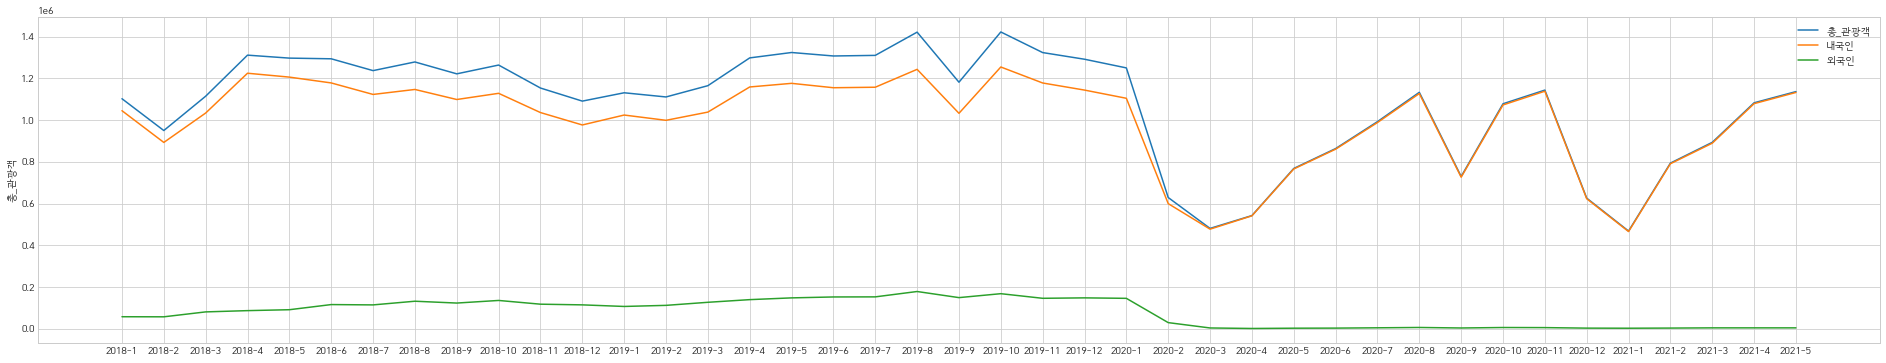

In [336]:
# 관광객 내도 현황 그래프
plt.figure(figsize=(33,6))
for i in tourist.columns[2:]:
    sns.lineplot(x=year_months[:-1],y=tourist[i], label=i)
plt.legend()

-------------------------

# 2. EDA_2

In [345]:
food_waste = pd.read_csv('data/01_음식물쓰레기.csv', encoding='cp949',low_memory=False)
food_waste.columns = ['date','도시','행정동_코드','행정동명','배출거점지역_코드','배출건수','배출량','총_지불금액']
food_waste = food_waste.sort_values(by='date').reset_index(drop=True)
food_waste['date'] = pd.to_datetime(food_waste['date'])
## 연도-월
food_waste['year_month'] = food_waste['date'].apply(lambda x : x.strftime('%Y-%m'))
## 일(day) 변수 생성
food_waste['day'] = food_waste['date'].dt.day
## 연도(year) 변수 생성
food_waste['year'] = food_waste['date'].dt.year
## 월(month) 변수 생성
food_waste['month'] = food_waste['date'].dt.month
food_waste = food_waste[['date','행정동명','year_month','year','month','day',"배출량"]]

### 알고리즘을 통한 군집 결과 확인

In [346]:
def get_linkage(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    return linkage_matrix

In [348]:
food_waste_df = pd.pivot_table(index='date', columns='행정동명', values='배출량', data=food_waste)
food_waste_df.shape

(1277, 42)

In [349]:
# 결측값 0
food_waste_df = food_waste_df.fillna(0)

In [350]:
# 타임 시리즈 형태로 전환
n_food_waste_df = to_time_series_dataset(food_waste_df.values.T)

In [351]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, affinity=cdist_dtw, linkage='complete')
model.fit(n_food_waste_df.reshape((n_food_waste_df.shape[0], n_food_waste_df.shape[1])))

AgglomerativeClustering(affinity=<function cdist_dtw at 0x000001B303C541F8>,
                        distance_threshold=0.5, linkage='complete',
                        n_clusters=None)

In [352]:
linkage_matrix = get_linkage(model)

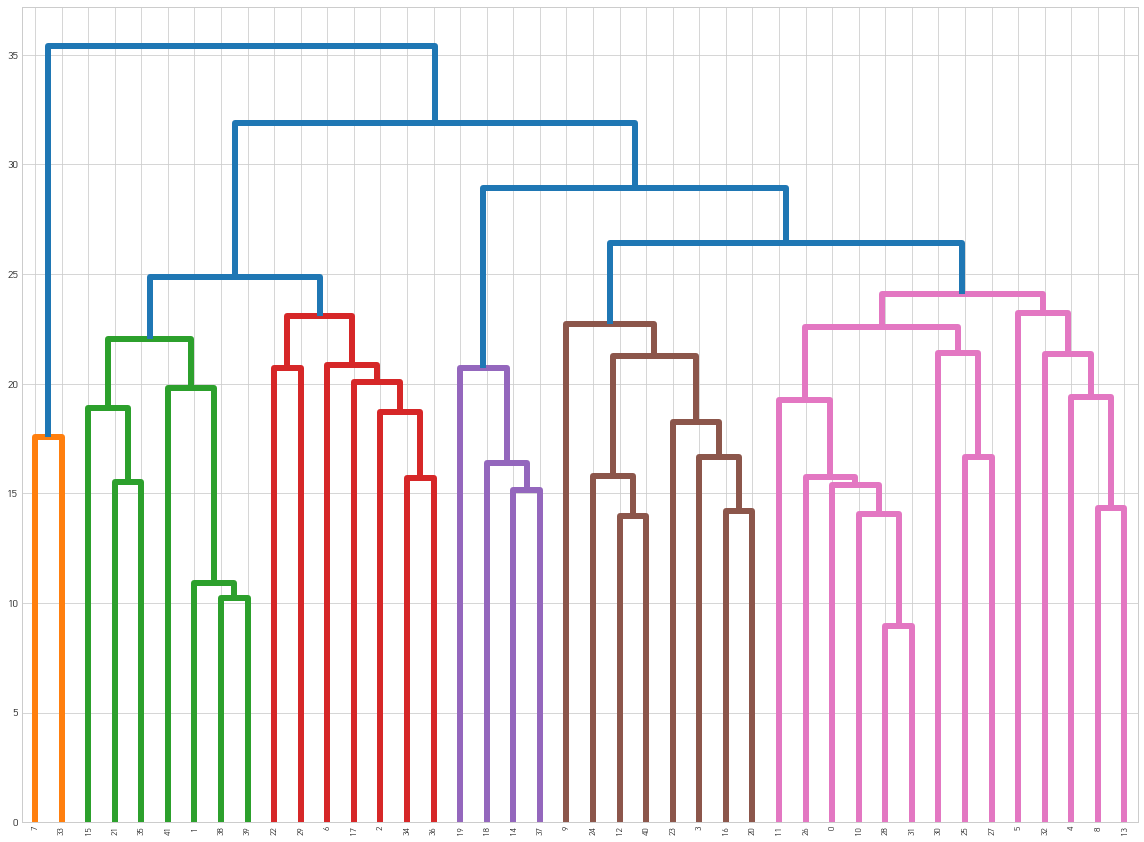

In [48]:
fig, axes = plt.subplots(figsize=(20, 15))
matplotlib.rcParams['lines.linewidth'] = 6
dendrogram(linkage_matrix, ax=axes)
plt.show()

In [354]:
### 1번 군집
g1 = food_waste[food_waste.행정동명.isin(["건입동", "노형동", "삼도1동", "삼도2동", "삼양동", "아라동", "연동", "오라동", "외도동","용담1동", "용담2동", "이도1동", "이도2동", "일도2동", "화북동"])]
g1_data = g1.groupby(['year_month'])['배출량'].sum().reset_index()
g1_data['year_month'] = pd.to_datetime(g1_data['year_month'])
g1_data = g1_data.set_index('year_month')


### 2번 군집
g2 = food_waste[food_waste.행정동명.isin(["구좌읍", "조천읍", "한경면", "한림읍"])]
g2_data = g2.groupby(['year_month'])['배출량'].sum().reset_index()
g2_data['year_month'] = pd.to_datetime(g2_data['year_month'])
g2_data = g2_data.set_index('year_month')


### 3번 군집
g3 = food_waste[food_waste.행정동명.isin(["남원읍", "대천동", "동홍동", "서홍동","중앙동"])]
g3_data = g3.groupby(['year_month'])['배출량'].sum().reset_index()
g3_data['year_month'] = pd.to_datetime(g3_data['year_month'])
g3_data = g3_data.set_index('year_month')


### 4번 군집
g4 = food_waste[food_waste.행정동명.isin(['송산동','대륜동','중문동'])]
g4_data = g4.groupby(['year_month'])['배출량'].sum().reset_index()
g4_data['year_month'] = pd.to_datetime(g4_data['year_month'])
g4_data = g4_data.set_index('year_month')


### 5번 군집
g5 = food_waste[food_waste.행정동명.isin(['천지동','정방동'])]
g5_data = g5.groupby(['year_month'])['배출량'].sum().reset_index()
g5_data['year_month'] = pd.to_datetime(g5_data['year_month'])
g5_data = g5_data.set_index('year_month')


### 6번 군집
g6 = food_waste[food_waste.행정동명.isin(["대정읍", "안덕면"])]
g6_data = g6.groupby(['year_month'])['배출량'].sum().reset_index()
g6_data['year_month'] = pd.to_datetime(g6_data['year_month'])
g6_data = g6_data.set_index('year_month')


### 7번 군집
g7 = food_waste[food_waste.행정동명.isin(["도두동", "봉개동", "예래동","이호동"])]
g7_data = g7.groupby(['year_month'])['배출량'].sum().reset_index()
g7_data['year_month'] = pd.to_datetime(g7_data['year_month'])
g7_data = g7_data.set_index('year_month')


### 8번 군집
g8 = food_waste[food_waste.행정동명.isin(["성산읍", "표선면"])]
g8_data = g8.groupby(['year_month'])['배출량'].sum().reset_index()
g8_data['year_month'] = pd.to_datetime(g8_data['year_month'])
g8_data = g8_data.set_index('year_month')


### 9번 군집
g9 = food_waste[food_waste.행정동명.isin(["알수없음"])]
g9_data = g9.groupby(['year_month'])['배출량'].sum().reset_index()
g9_data['year_month'] = pd.to_datetime(g9_data['year_month'])
g9_data = g9_data.set_index('year_month')


### 10번 군집
g10 = food_waste[food_waste.행정동명.isin(["애월읍"])]
g10_data = g10.groupby(['year_month'])['배출량'].sum().reset_index()
g10_data['year_month'] = pd.to_datetime(g10_data['year_month'])
g10_data = g10_data.set_index('year_month')


### 11번 군집
g11 = food_waste[food_waste.행정동명.isin(["영천동", "효돈동"])]
g11_data = g11.groupby(['year_month'])['배출량'].sum().reset_index()
g11_data['year_month'] = pd.to_datetime(g11_data['year_month'])
g11_data = g11_data.set_index('year_month')


### 12번 군집
g12 = food_waste[food_waste.행정동명.isin(["일도1동"])]
g12_data = g12.groupby(['year_month'])['배출량'].sum().reset_index()
g12_data['year_month'] = pd.to_datetime(g12_data['year_month'])
g12_data = g12_data.set_index('year_month')

In [355]:
all_data = food_waste.groupby('year_month')['배출량'].sum().reset_index()
all_data['year_month'] = pd.to_datetime(all_data['year_month'])
all_data.rename(columns = {'배출량':'전체_배출량'}, inplace=True)

In [356]:
city_data = food_waste.groupby(['행정동명','year_month'])['배출량'].sum().reset_index()
city_data['year_month'] = pd.to_datetime(city_data['year_month'])
city_data.rename(columns = {'배출량':'도시_배출량'}, inplace=True)

In [357]:
# 군집별 비율 구하는 함수
def proposition(g_data, title):
    g_data = g_data.reset_index()
    pro_df = pd.merge(all_data, g_data, on='year_month')
    pro_df['비율'] = pro_df['배출량']/pro_df['전체_배출량']

    pro_df2 = pd.merge(pro_df, city_data, on='year_month')
    pro_df2['군집내비율'] = pro_df2['도시_배출량']/pro_df2['배출량']
    pro_df2['year'] = pro_df2['year_month'].dt.year
    pro_df2['month'] = pro_df2['year_month'].dt.month
    
    ## 군집1의 경우 점점 내려간다
    plt.figure(figsize=(15,6))
    sns.lineplot(x='year_month', y='비율', data=pro_df)
    plt.title(title)
    
    return pro_df2[['year_month','행정동명','군집내비율']]

    
### 연도와 월별 각 동이 차지하는 비율
def propo_eda(year, month):
    prd_df_ex = pro_df2[(pro_df2['year']==year)&(pro_df2['month']==month)]
    plt.figure(figsize=(12,8))
    sns.barplot(x = prd_df_ex['행정동명'], y=prd_df_ex['군집내비율'], label='군집내비율')
    plt.ylim(0,0.1)
    plt.xticks(rotation = 45 )
    plt.legend()
    plt.title(f'{year}년_{month}월')

In [358]:
### ppt 그림 전체 행정동으로 했을 때의 비율
d1 = food_waste.groupby(['year','month','행정동명'])['배출량'].sum().reset_index().rename(columns={'배출량':'행정동_배출량'})
d2 = food_waste.groupby(['year','month'])['배출량'].sum().reset_index()

d3 = pd.merge(d1,d2, on=['year','month'])
d3['전체_비율'] = d3['행정동_배출량']/d3['배출량']
d3.head()

,year,month,행정동명,행정동_배출량,배출량,전체_비율
0,2018,1,건입동,45646550,2419027050,0.018870
1,2018,1,남원읍,42437700,2419027050,0.017543
2,2018,1,노형동,265018400,2419027050,0.109556
3,2018,1,대륜동,57612600,2419027050,0.023816
4,2018,1,대정읍,38885550,2419027050,0.016075


### 행정동 별 비율 차이 확인

In [359]:
def propo_eda_all(year, month):
    prd_df_ex = d3[(d3['year']==year)&(d3['month'].isin(month))].reset_index(drop=True)
    
    plt.figure(figsize=(12,8))
    sns.barplot(x = '행정동명', y='전체_비율', data=prd_df_ex, hue='month')
    
    plt.ylim(0,0.1)
    plt.xticks(rotation = 45 )
    plt.legend()
    plt.title(f'{year}년_{month}월')

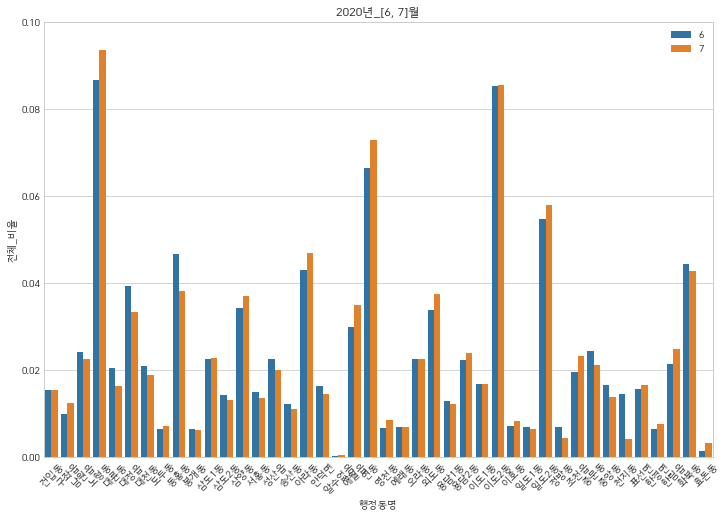

In [360]:
propo_eda_all(2020,[6,7])

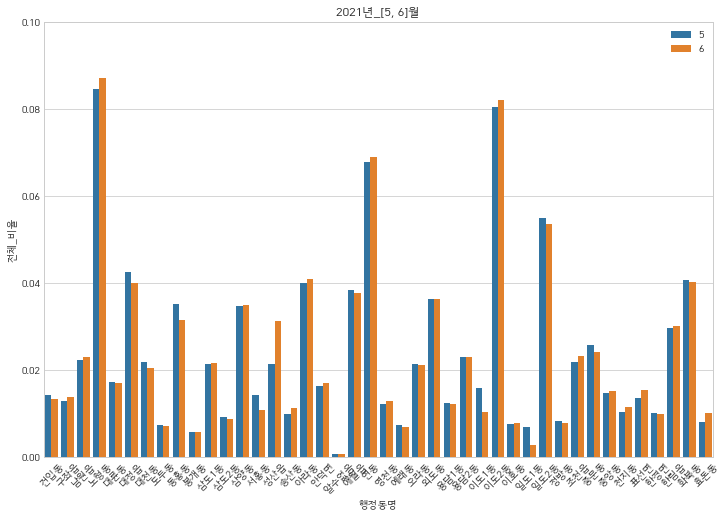

In [361]:
propo_eda_all(2021,[5,6])

### 환경오염 방지 설문조사 확인
- 제주도민의 인식 개선 필요

In [369]:
cdf1 = pd.read_csv('(kosis) 환경오염_방지_노력__음식물_쓰레기_줄이기__13세_이상_인구.csv', 
            encoding='euc-kr',
           header=1)

cdf1.columns = ['도시','카테고리','세부_카테고리','계','매우 노력함','약간 노력함','별로 노력하지 않음','전혀 노력하지 않음']

# 변수 버리기
cdf1.drop(['카테고리','계'], axis=1, inplace=True)

cdf1['전혀 노력하지 않음'] = cdf1['전혀 노력하지 않음'].map(lambda x: 0 if x=='-' else x).astype(float)

cdf1['하'] = cdf1['별로 노력하지 않음']+cdf1['전혀 노력하지 않음']
cdf1 = cdf1[['도시','세부_카테고리','매우 노력함','하']]
cdf1

,도시,세부_카테고리,매우 노력함,하
0,서울,계,41.9,13.1
1,서울,남자,38.1,14.9
2,서울,여자,45.4,11.3
3,서울,단독주택,48.9,11.5
4,서울,아파트,38.6,14.6
5,서울,기 타1,42.0,11.6
6,서울,초졸이하,50.2,11.9
7,서울,중 졸,47.8,10.0
8,서울,고 졸,42.4,13.3
9,서울,대졸이상,38.9,13.6


In [373]:
living_place = cdf1[cdf1.세부_카테고리.isin(['단독주택','아파트','기 타1'])]
living_place.head()

,도시,세부_카테고리,매우 노력함,하
3,서울,단독주택,48.9,11.5
4,서울,아파트,38.6,14.6
5,서울,기 타1,42.0,11.6
15,부산,단독주택,51.7,8.5
16,부산,아파트,43.6,10.9


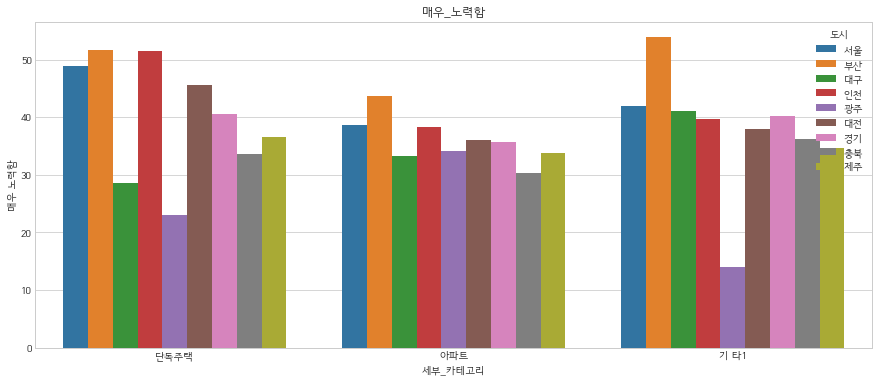

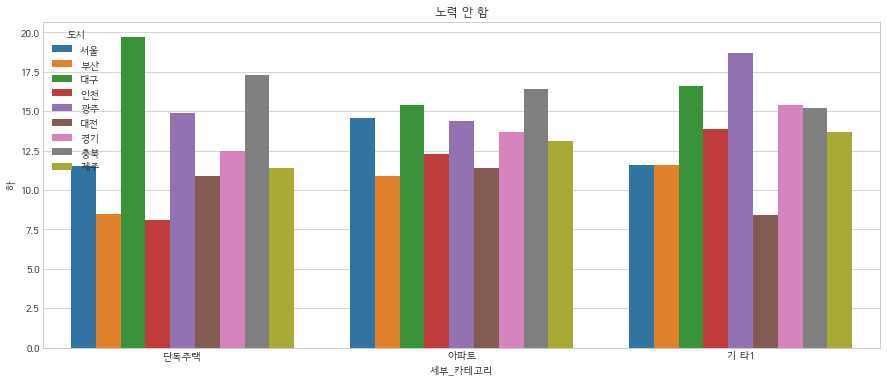

In [374]:
# living_place = cdf1[cdf1.index.isin(['단독주택','아파트','기 타1'])]
plt.figure(figsize = (15,6))
sns.barplot(x='세부_카테고리', y='매우 노력함', data=living_place, hue='도시')
plt.title('매우_노력함')
plt.show()

plt.figure(figsize = (15,6))
plt.title('노력 안 함')
sns.barplot(x='세부_카테고리', y='하', data=living_place, hue='도시')
plt.show()


<AxesSubplot:xlabel='세부_카테고리', ylabel='하'>

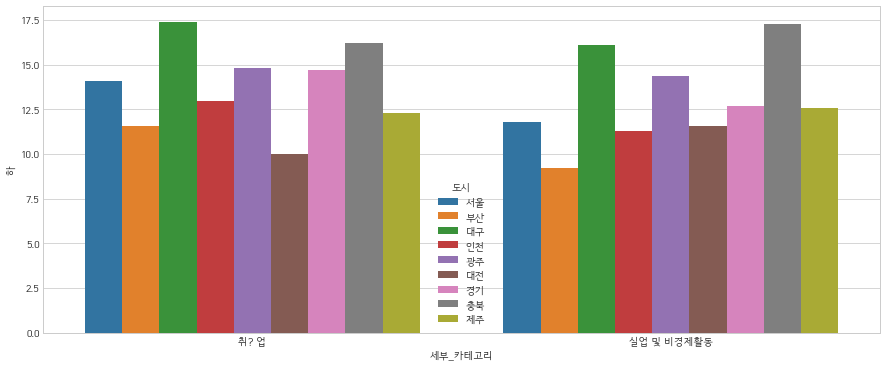

In [375]:
job = cdf1[cdf1.세부_카테고리.isin(['취? 업','실업 및 비경제활동'])]
plt.figure(figsize = (15,6))
sns.barplot(x='세부_카테고리', y='하', data=job, hue='도시')

---------------

# 3. EDA_3
* 추세가 비교적 안정적인 클러스터 1을 분석 대상으로 선정
* 클러스터 1 내에서 거주 인구가 많은 순으로 상위 5개 행정동에 대해 분석
* 제공 데이터 및 외부 데이터 활용

In [382]:
food_waste = pd.read_csv('data/01_음식물쓰레기.csv', encoding='cp949',low_memory=False)
food_waste.columns = ['date','도시','행정동_코드','행정동명','배출거점지역_코드','배출건수','배출량','총_지불금액']
food_waste = food_waste.sort_values(by='date').reset_index(drop=True)

add_data=pd.read_csv('data/추가데이터.csv')

In [383]:
cl1=["건입동", "노형동", "삼도1동", "삼도2동", "삼양동", "아라동", "연동", "오라동", "외도동","용담1동", "용담2동", "이도1동", "이도2동", "일도2동", "화북동"]

### Linear Regression 및 상관계수 확인을 통한 여름철 증가 변수들(기온,습도,강수량)과 배출량의 관계 확인

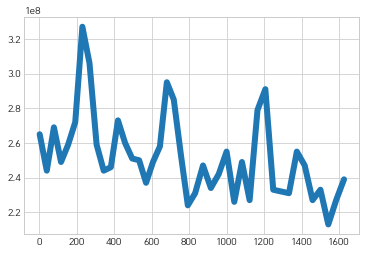

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     7.118
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.98e-05
Time:                        00:48:33   Log-Likelihood:                -753.47
No. Observations:                  42   AIC:                             1523.
Df Residuals:                      34   BIC:                             1537.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.962e+10   5.36e+09      3.657      0.0

In [384]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='노형동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

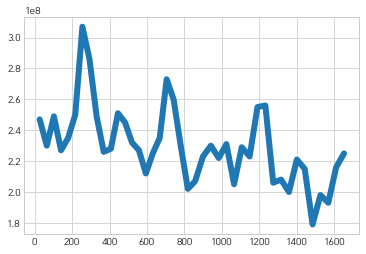

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     10.93
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           3.85e-07
Time:                        00:48:50   Log-Likelihood:                -749.44
No. Observations:                  42   AIC:                             1515.
Df Residuals:                      34   BIC:                             1529.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.452e+10   4.87e+09      5.040      0.0

In [385]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='이도2동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

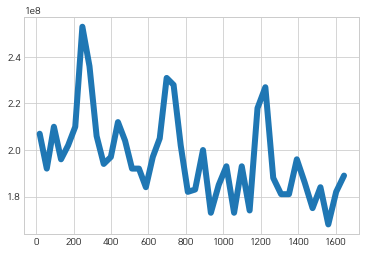

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     9.314
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.14e-06
Time:                        00:48:50   Log-Likelihood:                -739.44
No. Observations:                  42   AIC:                             1495.
Df Residuals:                      34   BIC:                             1509.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.615e+10   3.82e+09      4.234      0.0

In [386]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='연동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

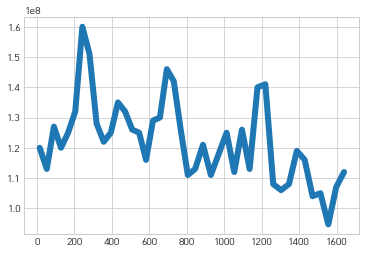

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     7.398
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.08e-05
Time:                        00:48:50   Log-Likelihood:                -729.54
No. Observations:                  42   AIC:                             1475.
Df Residuals:                      34   BIC:                             1489.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.285e+10   3.04e+09      4.235      0.0

In [387]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='아라동']
data['month']=data['month']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

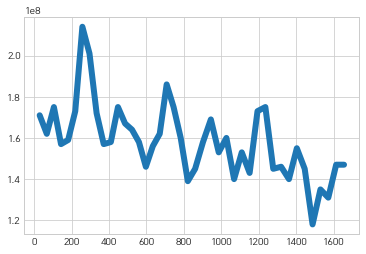

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     10.07
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           9.39e-07
Time:                        00:48:51   Log-Likelihood:                -737.01
No. Observations:                  42   AIC:                             1490.
Df Residuals:                      34   BIC:                             1504.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.948e+10   3.61e+09      5.392      0.0

In [388]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='일도2동']
data['month']=data['month']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

### 모델 축소 후 재확인

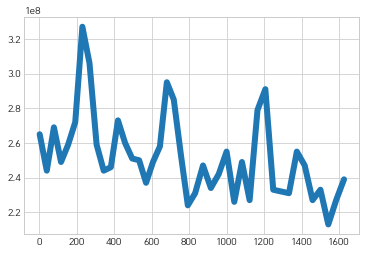

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     7.063
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           0.000109
Time:                        00:48:51   Log-Likelihood:                -758.06
No. Observations:                  42   AIC:                             1528.
Df Residuals:                      36   BIC:                             1539.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.171e+10   5.72e+09      3.793      0.0

In [389]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='노형동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data[['year','month','최고기온(℃)','강수량(mm)','평균습도(%rh)']]
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

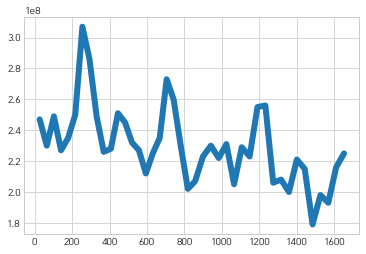

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     10.76
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.23e-06
Time:                        00:48:51   Log-Likelihood:                -755.00
No. Observations:                  42   AIC:                             1522.
Df Residuals:                      36   BIC:                             1532.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.623e+10   5.33e+09      4.926      0.0

In [390]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='이도2동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data[['year','month','최고기온(℃)','강수량(mm)','평균습도(%rh)']]
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

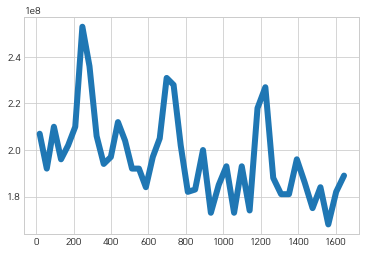

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     9.258
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           9.81e-06
Time:                        00:48:51   Log-Likelihood:                -744.57
No. Observations:                  42   AIC:                             1501.
Df Residuals:                      36   BIC:                             1512.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.768e+10   4.15e+09      4.259      0.0

In [391]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='연동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data[['year','month','최고기온(℃)','강수량(mm)','평균습도(%rh)']]
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

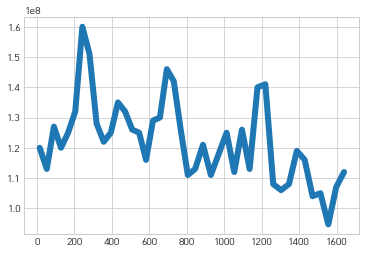

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     8.394
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.44e-05
Time:                        00:48:52   Log-Likelihood:                -732.75
No. Observations:                  42   AIC:                             1478.
Df Residuals:                      36   BIC:                             1488.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.382e+10   3.13e+09      4.413      0.0

In [392]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='아라동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data[['year','month','최고기온(℃)','강수량(mm)','평균습도(%rh)']]
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

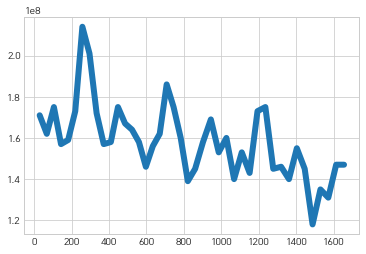

                            OLS Regression Results                            
Dep. Variable:                    배출량   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     9.018
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           1.26e-05
Time:                        00:48:52   Log-Likelihood:                -743.54
No. Observations:                  42   AIC:                             1499.
Df Residuals:                      36   BIC:                             1510.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.086e+10   4.05e+09      5.145      0.0

In [393]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='일도2동']
plt.plot(data.배출량)
plt.show()
lr=LinearRegression()
x=data[['year','month','최고기온(℃)','강수량(mm)','평균습도(%rh)']]
y=data['배출량']
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('상관계수 : ',data.corr()['배출량'])

#### 습도와 최고기온이 배출량과 유의한 관계에 있음을 확인

-----------------

### RandomForest Feature Importance 확인을 통한 관계 확인

In [394]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='노형동']
rf=RandomForestRegressor()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
rf.fit(x,y)
print(x.columns)
print(rf.feature_importances_)

Index(['year', 'month', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)', '강수량(mm)',
       '평균습도(%rh)'],
      dtype='object')
[0.16207379 0.02441644 0.27050122 0.29790258 0.11504698 0.05146649
 0.0785925 ]


In [395]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='이도2동']
rf=RandomForestRegressor()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
rf.fit(x,y)
print(x.columns)
print(rf.feature_importances_)

Index(['year', 'month', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)', '강수량(mm)',
       '평균습도(%rh)'],
      dtype='object')
[0.21071839 0.03642895 0.25731183 0.16620958 0.14023823 0.07717538
 0.11191763]


In [396]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='연동']
rf=RandomForestRegressor()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
rf.fit(x,y)
print(x.columns)
print(rf.feature_importances_)

Index(['year', 'month', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)', '강수량(mm)',
       '평균습도(%rh)'],
      dtype='object')
[0.19236547 0.02235504 0.293699   0.24440535 0.11680917 0.0514376
 0.07892838]


In [397]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='아라동']
rf=RandomForestRegressor()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
rf.fit(x,y)
print(x.columns)
print(rf.feature_importances_)

Index(['year', 'month', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)', '강수량(mm)',
       '평균습도(%rh)'],
      dtype='object')
[0.2221549  0.02593135 0.21573227 0.25265087 0.12709519 0.08018284
 0.07625257]


In [398]:
data=add_data.iloc[:,:8]
data['배출량']=add_data.배출량
data.dropna(inplace=True)
data=data[data.행정동명=='일도2동']
rf=RandomForestRegressor()
x=data.drop(['행정동명','배출량'],axis=1)
y=data['배출량']
rf.fit(x,y)
print(x.columns)
print(rf.feature_importances_)

Index(['year', 'month', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)', '강수량(mm)',
       '평균습도(%rh)'],
      dtype='object')
[0.26749216 0.0416867  0.15602638 0.22290924 0.15825664 0.07888643
 0.07474244]


#### RF의 경우, 강수량의 유의성 확인

------------

## 요일 및 주말 여부와 배출량의 관계 탐색

In [399]:
a=food_waste.date.drop_duplicates().reset_index(drop=True).reset_index()
a['index']=a['index']+1
a['index']=a['index']%7
a['weekend']=a['index'].apply(lambda x:1 if x in [0,6] else 0)
dict_weekend={}
for i in range(a.shape[0]):
    dict_weekend[a.iloc[i,1]]=a.iloc[i,2]
dict_weekend

b=food_waste.groupby(['date','행정동명']).배출량.sum().reset_index()
b['weekend']=b['date'].apply(lambda x:dict_weekend[x])
b

,date,행정동명,배출량,weekend
0,2018-01-01,건입동,1708250,0
1,2018-01-01,남원읍,1239600,0
2,2018-01-01,노형동,9357900,0
3,2018-01-01,대륜동,1717700,0
4,2018-01-01,대정읍,1264950,0
...,...,...,...,...
50517,2021-06-30,표선면,1377450,0
50518,2021-06-30,한경면,973850,0
50519,2021-06-30,한림읍,3298100,0
50520,2021-06-30,화북동,3749600,0


### 행정동별 주말/평일 집단 간 T-TEST

In [400]:
for i in cl1:
    print(i,stats.ttest_ind(b[(b.행정동명==i)&(b.weekend==1)].배출량,b[(b.행정동명==i)&(b.weekend==0)].배출량,equal_var=False))

건입동 Ttest_indResult(statistic=5.7466968910229745, pvalue=1.3778454750513034e-08)
노형동 Ttest_indResult(statistic=5.196942248282288, pvalue=2.8008493318705717e-07)
삼도1동 Ttest_indResult(statistic=4.239414510085449, pvalue=2.589794304118375e-05)
삼도2동 Ttest_indResult(statistic=3.283160191122603, pvalue=0.0010832848817915737)
삼양동 Ttest_indResult(statistic=6.954740856092865, pvalue=9.657683728918948e-12)
아라동 Ttest_indResult(statistic=6.078211578431457, pvalue=2.1901033014842097e-09)
연동 Ttest_indResult(statistic=5.741982858228335, pvalue=1.5114578884077342e-08)
오라동 Ttest_indResult(statistic=8.432122422309183, pvalue=2.698698978780684e-16)
외도동 Ttest_indResult(statistic=7.1577031113893925, pvalue=2.656073726239932e-12)
용담1동 Ttest_indResult(statistic=2.5740503957675656, pvalue=0.010273205918773207)
용담2동 Ttest_indResult(statistic=6.156498174952816, pvalue=1.3758203732061091e-09)
이도1동 Ttest_indResult(statistic=1.6626986162441504, pvalue=0.09685372361344863)
이도2동 Ttest_indResult(statistic=7.010168458

### 클러스터 1 전체 주말/평일 집단 간 T-TEST

In [401]:
stats.ttest_ind(b[(b.weekend==1)].배출량,b[(b.weekend==0)].배출량,equal_var=False)

Ttest_indResult(statistic=5.632822435570199, pvalue=1.791985794726885e-08)

### 행정동별 주말/평일 배출량 평균 단순 비교

In [402]:
for i in cl1:
    print(i,b[b.행정동명==i].groupby('weekend').배출량.mean())

건입동 weekend
0    1.389321e+06
1    1.481545e+06
Name: 배출량, dtype: float64
노형동 weekend
0    8.175527e+06
1    8.609726e+06
Name: 배출량, dtype: float64
삼도1동 weekend
0    2.109929e+06
1    2.221862e+06
Name: 배출량, dtype: float64
삼도2동 weekend
0    1.185793e+06
1    1.241248e+06
Name: 배출량, dtype: float64
삼양동 weekend
0    3.234235e+06
1    3.501539e+06
Name: 배출량, dtype: float64
아라동 weekend
0    3.943566e+06
1    4.226560e+06
Name: 배출량, dtype: float64
연동 weekend
0    6.376445e+06
1    6.759106e+06
Name: 배출량, dtype: float64
오라동 weekend
0    1.900051e+06
1    2.076137e+06
Name: 배출량, dtype: float64
외도동 weekend
0    3.093734e+06
1    3.335212e+06
Name: 배출량, dtype: float64
용담1동 weekend
0    1.187822e+06
1    1.223961e+06
Name: 배출량, dtype: float64
용담2동 weekend
0    2.130222e+06
1    2.284370e+06
Name: 배출량, dtype: float64
이도1동 weekend
0    1.491168e+06
1    1.521060e+06
Name: 배출량, dtype: float64
이도2동 weekend
0    7.402648e+06
1    7.986955e+06
Name: 배출량, dtype: float64
일도2동 weekend
0    5.092308e+06
1 

#### 주말/평일 간 배출량에 유의한 차이 존재함을 확인

----------

### 요일별 배출량 차이 탐색

In [403]:
a=food_waste.date.drop_duplicates().reset_index(drop=True).reset_index()
a['index']=a['index']+1
a['index']=a['index']%7
dict_요일={}
for i in range(a.shape[0]):
    dict_요일[a.iloc[i,1]]=a.iloc[i,0]
dict_요일

b=food_waste.groupby(['date','행정동명']).배출량.sum().reset_index()
b['요일']=b['date'].apply(lambda x:dict_요일[x])
b

,date,행정동명,배출량,요일
0,2018-01-01,건입동,1708250,1
1,2018-01-01,남원읍,1239600,1
2,2018-01-01,노형동,9357900,1
3,2018-01-01,대륜동,1717700,1
4,2018-01-01,대정읍,1264950,1
...,...,...,...,...
50517,2021-06-30,표선면,1377450,3
50518,2021-06-30,한경면,973850,3
50519,2021-06-30,한림읍,3298100,3
50520,2021-06-30,화북동,3749600,3


### 요일별 배출량 평균 단순 비교
#### * 클러스터 1의 경우 전체 행정동에서 일요일이 다른 요일과 유의한 차이 있음을 발견

In [404]:
for i in cl1:
    print(i,b[b.행정동명==i].groupby('요일').배출량.mean().sort_values(ascending=False))

건입동 요일
0    1.571032e+06
1    1.437643e+06
2    1.408023e+06
4    1.408016e+06
6    1.391565e+06
3    1.358689e+06
5    1.334032e+06
Name: 배출량, dtype: float64
노형동 요일
0    9.302993e+06
1    8.694283e+06
2    8.204627e+06
4    8.197082e+06
3    8.034234e+06
6    7.916460e+06
5    7.745177e+06
Name: 배출량, dtype: float64
삼도1동 요일
0    2.373522e+06
1    2.173319e+06
4    2.158972e+06
2    2.136519e+06
3    2.076266e+06
6    2.070202e+06
5    2.004259e+06
Name: 배출량, dtype: float64
삼도2동 요일
0    1.316227e+06
4    1.213680e+06
1    1.202243e+06
2    1.194202e+06
3    1.174763e+06
6    1.166268e+06
5    1.144001e+06
Name: 배출량, dtype: float64
삼양동 요일
0    3.850190e+06
1    3.458901e+06
2    3.239996e+06
4    3.239870e+06
3    3.192574e+06
6    3.152887e+06
5    3.038795e+06
Name: 배출량, dtype: float64
아라동 요일
0    4.588811e+06
1    4.213352e+06
2    3.979111e+06
4    3.967905e+06
6    3.864309e+06
3    3.850768e+06
5    3.705525e+06
Name: 배출량, dtype: float64
연동 요일
0    7.224828e+06
1    6.618093e+06
2 

#### * 전체 행정동에 대해 비교한 결과, 서귀포시를 제외한 대부분은 일요일이 유의한 차이가 있음.
#### * 서귀포시의 경우 요일별 큰 차이가 없음을 발견

In [405]:
for i in b.행정동명.unique():
    print(i,b[b.행정동명==i].groupby('요일').배출량.mean().sort_values(ascending=False))

건입동 요일
0    1.571032e+06
1    1.437643e+06
2    1.408023e+06
4    1.408016e+06
6    1.391565e+06
3    1.358689e+06
5    1.334032e+06
Name: 배출량, dtype: float64
남원읍 요일
6    1.782412e+06
1    1.771110e+06
5    1.751444e+06
0    1.746795e+06
2    1.725387e+06
4    1.687669e+06
3    1.672133e+06
Name: 배출량, dtype: float64
노형동 요일
0    9.302993e+06
1    8.694283e+06
2    8.204627e+06
4    8.197082e+06
3    8.034234e+06
6    7.916460e+06
5    7.745177e+06
Name: 배출량, dtype: float64
대륜동 요일
0    1.763547e+06
1    1.699692e+06
4    1.612533e+06
2    1.609692e+06
3    1.602211e+06
6    1.596173e+06
5    1.575810e+06
Name: 배출량, dtype: float64
대정읍 요일
0    2.732880e+06
1    2.720923e+06
6    2.664492e+06
5    2.661000e+06
4    2.649395e+06
2    2.640125e+06
3    2.597831e+06
Name: 배출량, dtype: float64
대천동 요일
0    1.867698e+06
1    1.756770e+06
6    1.694266e+06
2    1.660758e+06
4    1.656591e+06
3    1.642012e+06
5    1.622200e+06
Name: 배출량, dtype: float64
도두동 요일
0    651322.527473
1    568025.136612
2

### 클러스터 1 행정동별, 여름철 변수(최고기온, 강수량, 습도) 및 불쾌지수와 배출량 패턴 시각화

건입동


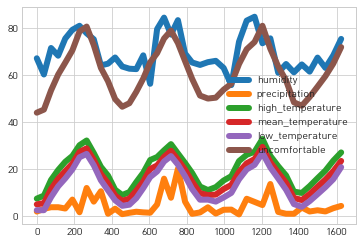

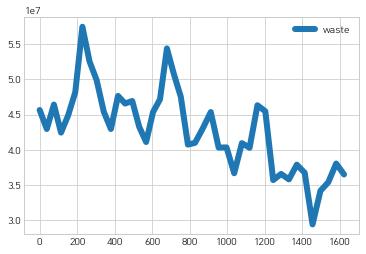

노형동


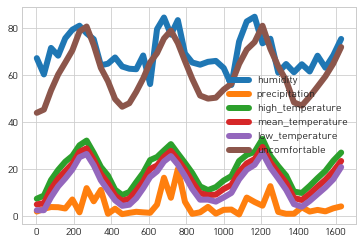

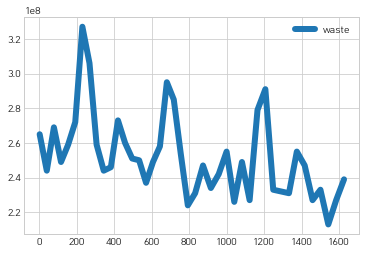

삼도1동


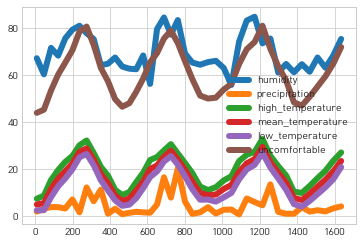

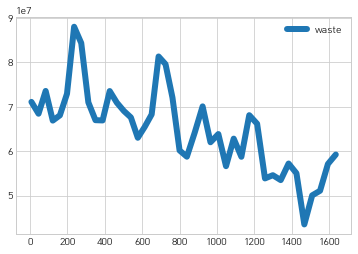

삼도2동


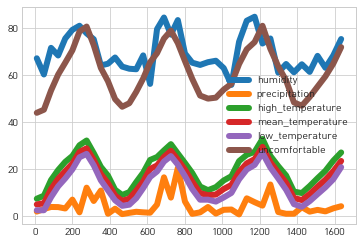

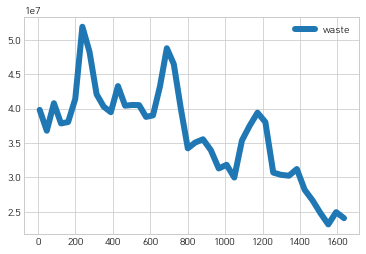

삼양동


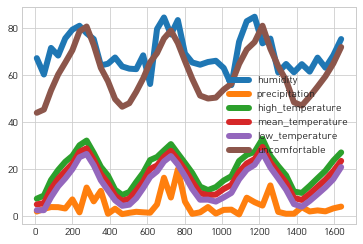

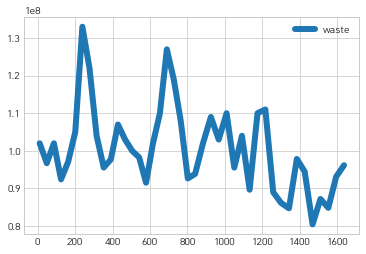

아라동


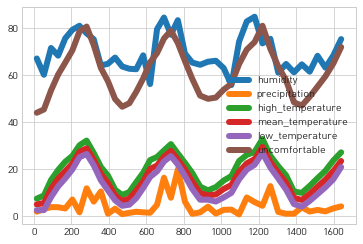

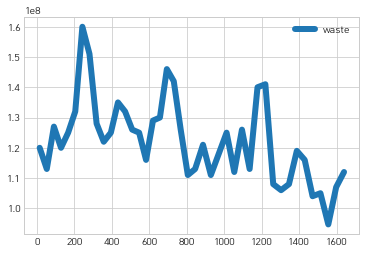

연동


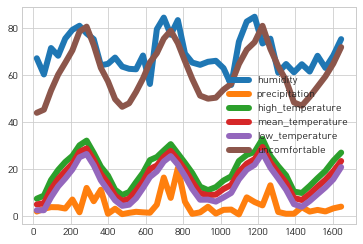

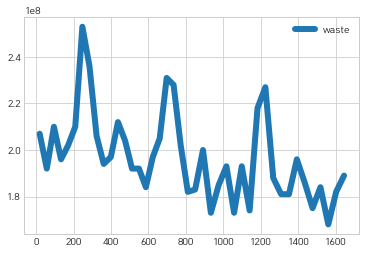

오라동


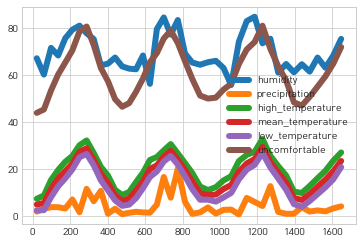

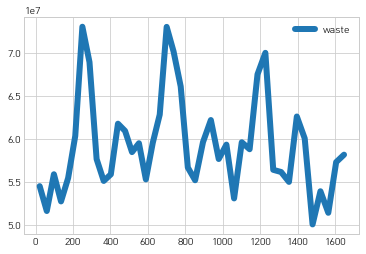

외도동


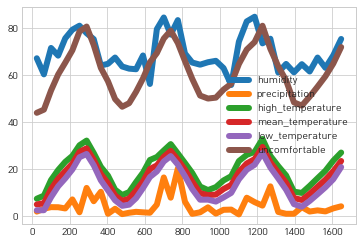

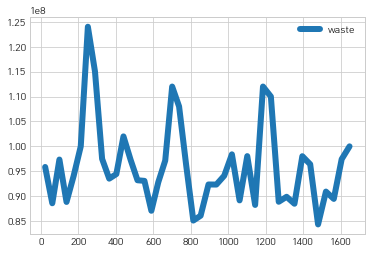

용담1동


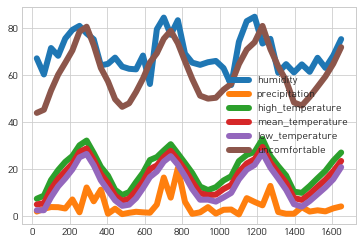

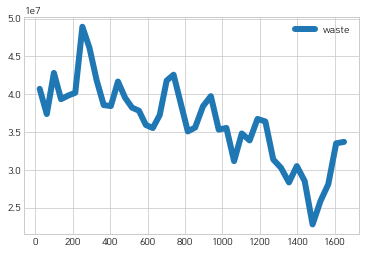

용담2동


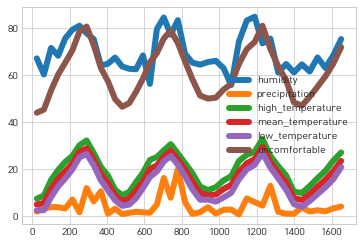

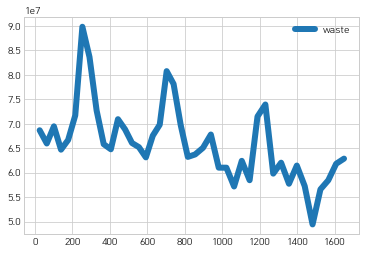

이도1동


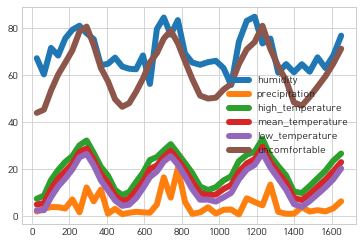

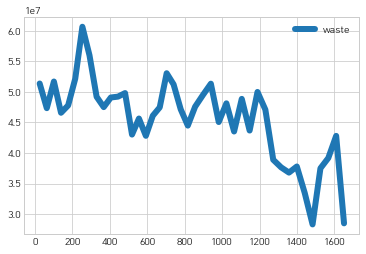

이도2동


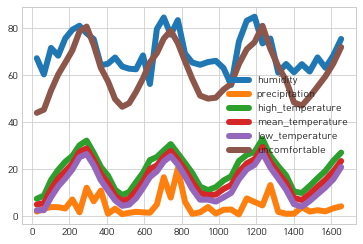

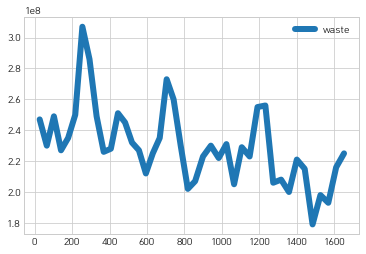

일도2동


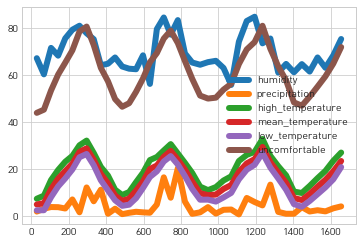

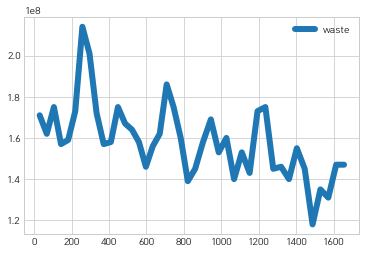

화북동


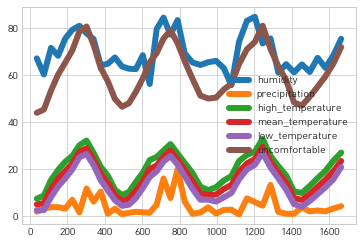

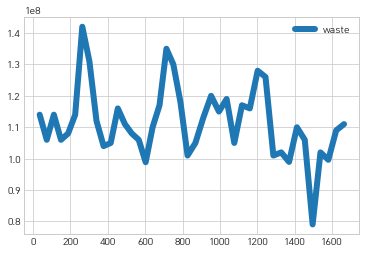

In [406]:
for i in cl1:
    data_i=add_data[add_data.행정동명==i]
    print(i)
    plt.plot(data_i['평균습도(%rh)'],label='humidity')
    plt.plot(data_i['강수량(mm)'],label='precipitation')
    plt.plot(data_i['최고기온(℃)'],label='high_temperature')
    plt.plot(data_i['평균기온(℃)'],label='mean_temperature')
    plt.plot(data_i['최저기온(℃)'],label='low_temperature')
    plt.plot(data_i['불쾌지수'],label='uncomfortable')
    plt.legend()
    plt.show()
    plt.plot(data_i['배출량'],label='waste')
    plt.legend()
    plt.show()

#### 이로써 여름철 배출량이 증가한다는 것을 검증

### 관광객과 여름 계절의 상관성 탐색
#### * 관광객 수와 대표적인 여름 변수(습도)의 패턴 시각화 및 상관계수 비교
#### * 제주도 전체 기준

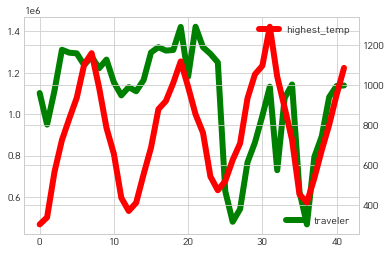

0.30795915178672384


In [407]:
fig, ax1 = plt.subplots()
ax1.plot(add_data.groupby(['year','month']).총_관광객.max().values,color='green',label='traveler')
plt.legend(loc='lower right')
ax2 = ax1.twinx()
ax2.plot(add_data.groupby(['year','month'])['최고기온(℃)'].sum().values,color='red',label='highest_temp')
plt.legend(loc='upper right')
plt.show()
print(pd.DataFrame([add_data.groupby(['year','month']).총_관광객.max().values,add_data.groupby(['year','month'])['최고기온(℃)'].sum().values]).T.corr().iloc[0,1])

#### * 관광객 수와 배출량의 패턴 시각화 및 상관계수 비교
#### * 제주도 전체 기준

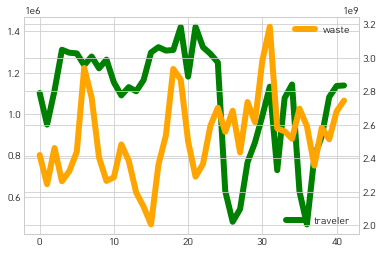

0.20615538770468309


In [408]:
fig, ax1 = plt.subplots()
ax1.plot(add_data.groupby(['year','month']).총_관광객.max().values,color='green',label='traveler')
plt.legend(loc='lower right')
ax2 = ax1.twinx()
ax2.plot(add_data.groupby(['year','month'])['배출량'].sum().values,color='orange',label='waste')
plt.legend(loc='upper right')
plt.show()
print(pd.DataFrame([data_i.groupby(['year','month']).총_관광객.max().values,data_i.groupby(['year','month'])['배출량'].sum().values]).T.corr().iloc[0,1])

### 관광객 수의 경우, 배출량과 아주 밀접한 관계는 아니지만, 여름철 배출량 증가에 있어 어느 정도의 설명력을 지닐 수 있을 것

---------

### 거주인구와 배출량의 상관성 확인
#### * 거주인구가 배출량과 직결되는 변수라고 가정했으나, 그렇지 않은 경우가 많다는 것을 확인
#### * 클러스터별 합산 비교

In [411]:
data_day=food_waste.groupby(['date','행정동명']).배출량.sum().reset_index()
data_sum=data_day.groupby('date').배출량.sum().reset_index().drop('date',axis=1)

cl1=["건입동", "노형동", "삼도1동", "삼도2동", "삼양동", "아라동", "연동", "오라동", "외도동","용담1동", "용담2동", "이도1동", "이도2동", "일도2동", "화북동"]
cl2=["구좌읍", "조천읍", "한경면", "한림읍"]
cl3=["남원읍", "대천동", "동홍동", "서홍동","중앙동"]
cl4=['송산동','대륜동','중문동']
cl5=['천지동','정방동']
cl6=["대정읍", "안덕면"]
cl7=["도두동", "봉개동", "예래동","이호동"]
cl8=["성산읍", "표선면"]
cl9=["알수없음"]
cl10=["애월읍"]
cl11=["영천동", "효돈동"]
cl12=["일도1동"]
cl=[cl1,cl2,cl3,cl4,cl5,cl6,cl7,cl8,cl9,cl10,cl11,cl12]
data_day['클러스터']='X'
for k,i in enumerate(cl):
    data_day.loc[data_day.행정동명.apply(lambda x:x in i),'클러스터']=k+1

['건입동', '노형동', '삼도1동', '삼도2동', '삼양동', '아라동', '연동', '오라동', '외도동', '용담1동', '용담2동', '이도1동', '이도2동', '일도2동', '화북동']


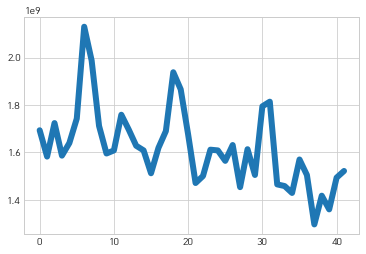

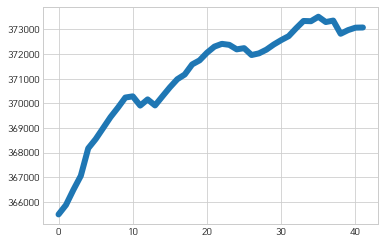

['구좌읍', '조천읍', '한경면', '한림읍']


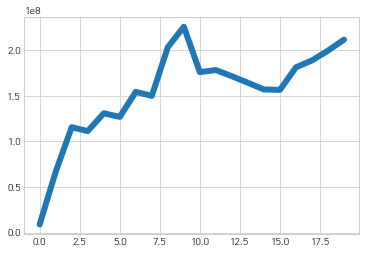

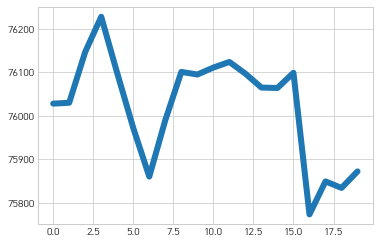

['남원읍', '대천동', '동홍동', '서홍동', '중앙동']


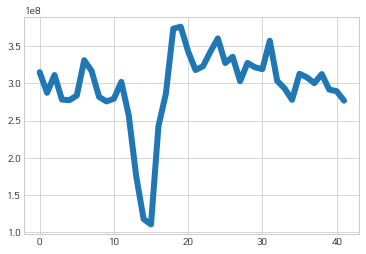

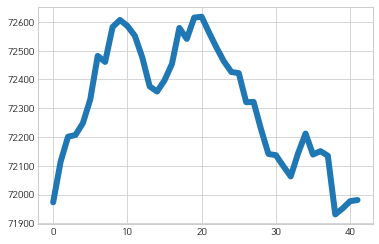

['송산동', '대륜동', '중문동']


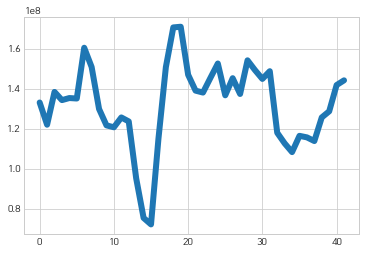

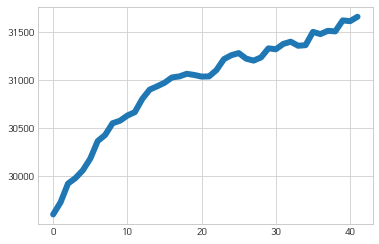

['천지동', '정방동']


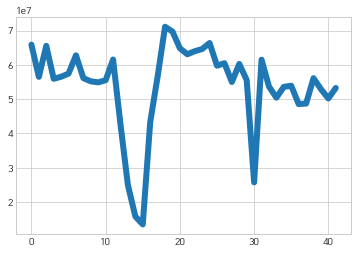

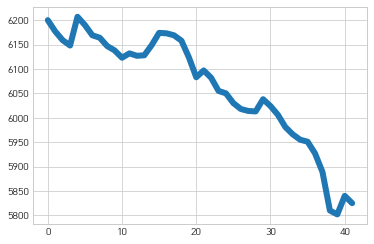

['대정읍', '안덕면']


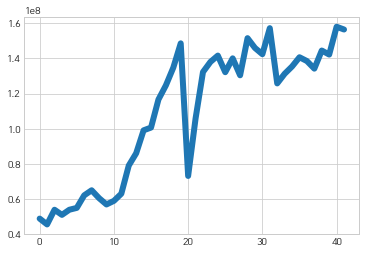

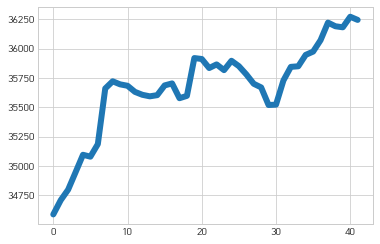

['도두동', '봉개동', '예래동', '이호동']


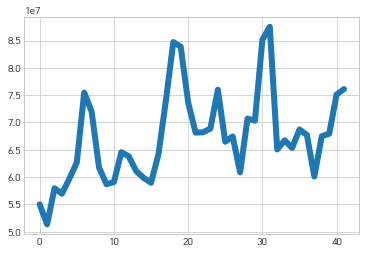

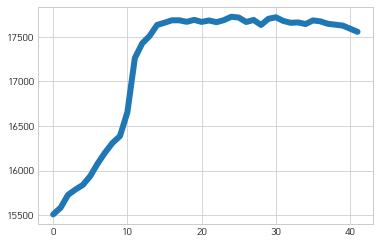

['성산읍', '표선면']


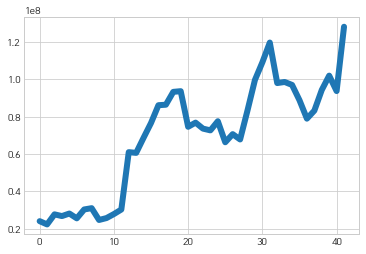

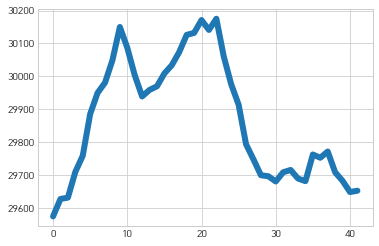

['알수없음']


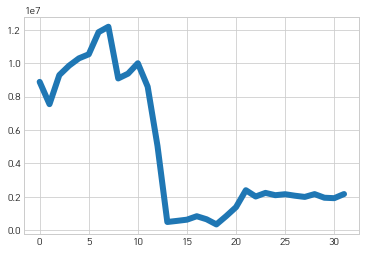

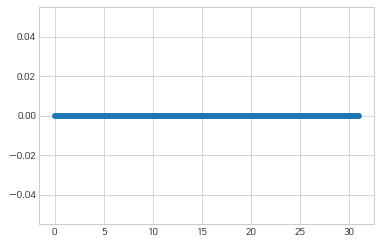

['애월읍']


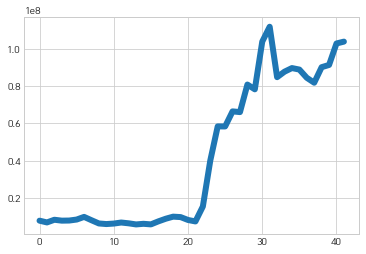

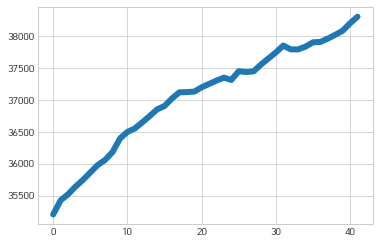

['영천동', '효돈동']


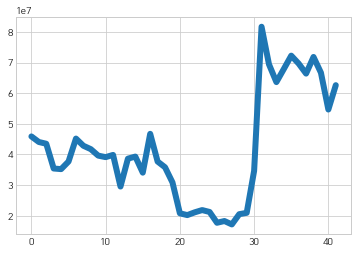

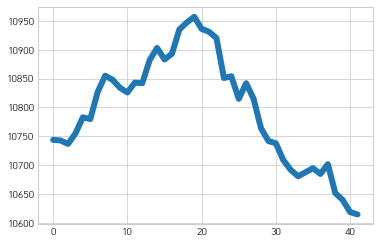

['일도1동']


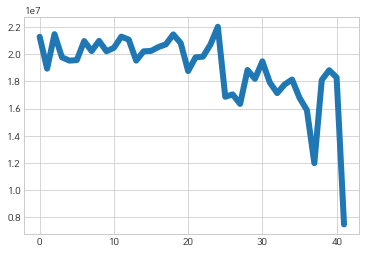

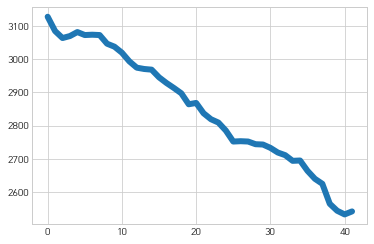

In [412]:
clusters=[cl1,cl2,cl3,cl4,cl5,cl6,cl7,cl8,cl9,cl10,cl11,cl12]
for i in clusters:
    print(i)
    plt.plot(add_data[add_data.행정동명.apply(lambda x:x in i)].groupby(['year','month']).배출량.sum().values)
    plt.show()
    plt.plot(add_data[add_data.행정동명.apply(lambda x:x in i)].groupby(['year','month'])['총_거주인구'].sum().values)
    plt.show()

------

# 4. 최종 모델링

In [413]:
food_waste = pd.read_csv('data/01_음식물쓰레기.csv', encoding='cp949',low_memory=False)
food_waste.columns = ['date','도시','행정동_코드','행정동명','배출거점지역_코드','배출건수','배출량','총_지불금액']
food_waste = food_waste.sort_values(by='date').reset_index(drop=True)
food_waste['date'] = pd.to_datetime(food_waste['date'])

## 연도-월
food_waste['year_month'] = food_waste['date'].apply(lambda x : x.strftime('%Y-%m'))
## 일(day) 변수 생성
food_waste['day'] = food_waste['date'].dt.day
## 연도(year) 변수 생성
food_waste['year'] = food_waste['date'].dt.year
## 월(month) 변수 생성
food_waste['month'] = food_waste['date'].dt.month

food_waste = food_waste[['date','행정동명','year_month','year','month','day',"배출량"]]

## 군집화

In [414]:
### 1번 군집
g1 = food_waste[food_waste.행정동명.isin(["건입동", "노형동", "삼도1동", "삼도2동", "삼양동", "아라동", "연동", "오라동", "외도동","용담1동", "용담2동", "이도1동", "이도2동", "일도2동", "화북동"])]
g1_data = g1.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g1_data.shape)

### 2번 군집
g2 = food_waste[food_waste.행정동명.isin(["구좌읍", "조천읍", "한경면", "한림읍"])]
g2_data = g2.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g2_data.shape)

### 3번 군집 -> 데이터 축소
g3 = food_waste[food_waste.행정동명.isin(["남원읍", "대천동", "동홍동", "서홍동","중앙동"])]
g3_data = g3.groupby(['date'])['배출량'].sum().reset_index()
g3_data = g3_data[g3_data['date']>='2019-07'].drop('date', axis=1)
print(g3_data.shape)

### 4번 군집
g4 = food_waste[food_waste.행정동명.isin(['송산동','대륜동','중문동'])]
g4_data = g4.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g4_data.shape)

### 5번 군집 -> 데이터 축소
g5 = food_waste[food_waste.행정동명.isin(['천지동','정방동'])]
g5_data = g5.groupby(['date'])['배출량'].sum().reset_index()
g5_data = g5_data[g5_data['date']>='2019-06'].drop('date', axis=1)
print(g5_data.shape)

### 6번 군집 -> 데이터 축소
g6 = food_waste[food_waste.행정동명.isin(["대정읍", "안덕면"])]
g6_data = g6.groupby(['date'])['배출량'].sum().reset_index()
g6_data = g6_data[g6_data['date']>='2019-11'].drop('date', axis=1)
print(g6_data.shape)

### 7번 군집
g7 = food_waste[food_waste.행정동명.isin(["도두동", "봉개동", "예래동","이호동"])]
g7_data = g7.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g7_data.shape)

### 8번 군집
g8 = food_waste[food_waste.행정동명.isin(["성산읍", "표선면"])]
g8_data = g8.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g8_data.shape)

### 9번 군집
g9 = food_waste[food_waste.행정동명.isin(["알수없음"])]
g9_data = g9.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g9_data.shape)

### 10번 군집
g10 = food_waste[food_waste.행정동명.isin(["애월읍"])]
g10_data = g10.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g10_data.shape)

### 11번 군집
g11 = food_waste[food_waste.행정동명.isin(["영천동", "효돈동"])]
g11_data = g11.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g11_data.shape)

### 12번 군집
g12 = food_waste[food_waste.행정동명.isin(["일도1동"])]
g12_data = g12.groupby(['date'])['배출량'].sum().reset_index().drop('date', axis=1)
print(g12_data.shape)

(1277, 1)
(605, 1)
(730, 1)
(1276, 1)
(760, 1)
(607, 1)
(1277, 1)
(1276, 1)
(913, 1)
(1273, 1)
(1276, 1)
(1264, 1)


## window_size 지정

In [415]:
## 데이터 분할
def make_dataset(data,window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(data.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [416]:
## 예측
cluster_list = [g1_data, g2_data, g3_data, g4_data, g5_data, g6_data, g7_data, g8_data, g9_data, g10_data, g11_data, g12_data]

window_size=30
test_78 = []
for t,cluster_i in zip(range(1,13), cluster_list):
    train_feature, train_label = make_dataset(cluster_i,window_size=window_size)

    ## target
    train_x=train_feature.reshape(-1,window_size)
    print(train_x.shape)
    train_y=train_label
    print(train_y.shape)

    ## modeling
    rf=RandomForestRegressor(random_state=2021,
                            n_estimators=5000)
    rf.fit(train_x,train_y)
    print(train_x)
    ## 예측
    pred=np.array([])
    j=0
    for i in tqdm(range(0,62)):
        if i==0:
            test_x = np.array(cluster_i[-30:]).reshape(1,30)
            pred = np.append(pred, rf.predict(test_x))
        elif i>0 and i<=29:
            test_x = np.array(cluster_i[-30+i:]).reshape(1,-1)
            test_x = np.append(test_x, pred).reshape(1,30)
            pred = np.append(pred, rf.predict(test_x))
        else:
            test_x = pred[j:i].reshape(-1,30)
            pred = np.append(pred, rf.predict(test_x))
            j+=1
    test_78.append(pred)
    print(pred)
    print()
    print('cluster',t)
    print('#############################################################################')

(1247, 30)
(1247, 1)
[[62178650 63891150 56250300 ... 57908350 50251100 52882950]
 [63891150 56250300 57336800 ... 50251100 52882950 50282450]
 [56250300 57336800 51433050 ... 52882950 50282450 54941050]
 ...
 [48389150 58703850 50943550 ... 46426450 49613900 58644250]
 [58703850 50943550 48393300 ... 49613900 58644250 52213750]
 [50943550 48393300 48250950 ... 58644250 52213750 50067850]]


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.82it/s]


[49758741.4828 47559598.2516 50439844.2984 57453363.084  51941542.0322
 49543669.3668 49515195.9304 49544543.0134 47974508.4598 50145337.9862
 57323682.7492 52509161.529  50118445.4776 49709448.082  50349268.8384
 48493037.9624 50174392.2534 57911656.0796 52986809.819  50499701.8754
 49868008.9996 50572614.93   48612194.6292 50258865.57   57901577.438
 53304257.1688 50805889.7948 50233302.3504 50728901.2962 48693917.3012
 50428514.0412 57883251.9336 53503350.2708 51105132.6556 50438431.1022
 50756916.9386 48801154.136  50402049.3094 57843136.314  53694493.189
 51293859.4532 50571417.9146 50858161.903  48862696.4122 50388378.6746
 58018807.7496 53976882.0408 51568259.6538 50708921.3462 50851723.2126
 48951137.1746 50415370.6298 57787692.398  53781111.416  51728577.0828
 50704604.8446 50845150.4256 48970240.0834 50371733.7694 57812195.181
 53873319.2818 51920234.2856]

cluster 1
#############################################################################
(575, 30)
(575, 1)
[[   6150   3

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.73it/s]


[7174948.4004 7348524.8672 7474690.3888 7530158.5208 7709029.7896
 7304072.1712 7133233.1608 7393443.2236 7378944.4096 7238098.168
 7302550.8588 7513711.5684 7314590.3528 6795486.6204 7086299.816
 7058618.7148 7092057.9124 7133662.672  7270200.2704 7185508.75
 7083249.6396 7189923.1424 7098750.706  7179205.488  7153796.364
 7205996.9092 7166180.192  7153023.2776 7197362.6816 7124352.1396
 7194278.448  7164902.16   7196511.0072 7202094.1808 7218937.798
 7224012.806  7186265.0792 7263010.8512 7221156.92   7225416.7996
 7287750.7716 7266081.1212 7260646.1464 7264561.1392 7282626.4132
 7257126.2108 7256888.398  7272766.3596 7278669.88   7294621.5124
 7277515.336  7275999.9484 7271744.1392 7270638.558  7270946.7708
 7272136.3268 7281697.094  7280784.1484 7273898.952  7274221.7756
 7263347.9536 7261461.682 ]

cluster 2
#############################################################################
(700, 30)
(700, 1)
[[11250150 12246750 11084250 ... 12645450 13987200 12729550]
 [12246750 110842

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.68it/s]


[10040753.2004 10247544.6486 10316999.5506 10415517.2402 10409180.5944
 10219975.6816  9822706.2326 10178125.9672 10139758.1584 10375065.9404
 10408996.5626 10281195.1594 10169463.334  10117821.8042 10088405.4882
 10256655.4514 10320573.5792 10382329.619  10343285.6934 10170451.1876
 10142943.6146 10207031.5928 10308141.7856 10431307.239  10472705.9554
 10372525.2192 10255265.8346 10271538.9048 10277220.6216 10414310.1506
 10514523.4684 10551956.112  10416686.2772 10340251.8576 10309916.8408
 10367551.4016 10462671.5278 10559292.247  10548664.2768 10475995.3084
 10405599.9926 10381271.0018 10471583.357  10508012.6516 10559355.1284
 10580163.4248 10513966.3644 10460849.3064 10489863.3644 10514302.5678
 10551919.4232 10583921.2906 10583845.8688 10545706.1216 10529377.0476
 10539890.3334 10555366.5816 10578095.312  10588158.296  10568888.3574
 10550321.4618 10543234.4966]

cluster 3
#############################################################################
(1246, 30)
(1246, 1)
[[402245

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.71it/s]


[4949308.8582 4927796.6832 4953299.315  4974845.1236 4925693.6274
 4828778.6736 4821670.2024 4884501.2918 4800183.2176 4907378.8254
 4873717.7956 4805667.615  4826242.3428 4787751.7182 4826224.3778
 4797192.3586 4814512.5842 4735216.1868 4771002.3136 4714003.1012
 4677518.3804 4635442.9824 4678546.485  4695895.0484 4654806.2358
 4691095.0458 4692683.7672 4653195.5176 4714561.5304 4717457.896
 4679555.194  4707089.7924 4710318.0296 4679061.2848 4697619.4086
 4691176.5882 4678802.5524 4694417.4368 4684995.8208 4673443.8824
 4686798.4746 4669308.7324 4674528.33   4676734.661  4659226.9906
 4673456.9034 4665803.9748 4642241.0022 4662863.0054 4664384.9018
 4639403.9038 4645990.1478 4655913.9538 4644817.3226 4640762.0736
 4643728.5392 4642853.8554 4641463.9366 4642703.06   4643129.874
 4643830.1986 4640268.6238]

cluster 4
#############################################################################
(730, 30)
(730, 1)
[[1682650 1783950 1741250 ... 2412900 2040050 2367400]
 [1783950 1741250 1

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.72it/s]


[1912618.93 1891074.27 1912177.6  1876569.52 1888911.43 1907490.72
 1875326.52 1864713.47 1904980.4  1871333.04 1881944.55 1882806.87
 1848259.8  1858297.67 1858962.69 1839621.83 1831179.99 1836176.5
 1817737.27 1823512.2  1822216.8  1816616.11 1819238.33 1815517.1
 1812220.6  1810713.86 1811848.07 1809826.35 1802536.   1798920.85
 1800556.5  1797887.97 1799912.5  1800642.92 1794402.09 1798139.47
 1791469.25 1793543.36 1785254.36 1791588.07 1779091.33 1780715.69
 1770032.77 1770960.39 1767644.24 1767628.03 1768769.03 1769299.26
 1768155.26 1767754.2  1765068.58 1764876.08 1761705.2  1761636.44
 1761546.35 1758800.3  1747727.62 1736724.1  1712089.98 1702667.25
 1690768.35 1679506.76]

cluster 5
#############################################################################
(577, 30)
(577, 1)
[[4031200 4264250 4435250 ... 4743300 4509800 4456400]
 [4264250 4435250 4367700 ... 4509800 4456400 3802150]
 [4435250 4367700 4120100 ... 4456400 3802150 4831950]
 ...
 [5285400 5547550 5894750 ... 

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.73it/s]


[5119375.9744 5069427.12   5330514.0174 5131930.6052 5068099.6888
 4974616.7502 5198289.2548 5254795.6676 5160590.1848 5167864.8542
 5081668.6442 5368817.7804 5115869.8096 5195777.5764 5055796.3956
 5284435.436  5274774.7216 5315505.2876 5218445.1024 5123605.3802
 5139401.8844 5315793.789  5349203.1046 5331225.0544 5232042.13
 5166882.8006 5270076.1188 5235249.9548 5316771.266  5296526.1328
 5231463.0668 5219298.9398 5270819.4818 5321702.3576 5244187.1234
 5289176.191  5228177.0114 5366738.709  5262742.2662 5299228.1632
 5143869.681  5303290.0294 5311752.0994 5317607.521  5285791.8224
 5238811.2962 5229496.5612 5296136.4312 5291671.0486 5312727.9406
 5263880.4444 5252919.3138 5249665.6156 5292705.252  5279715.5744
 5287939.3258 5263689.2648 5288597.4636 5262725.171  5297122.2534
 5269790.1064 5289435.6426]

cluster 6
#############################################################################
(1247, 30)
(1247, 1)
[[2040450 2385200 1662650 ... 1823100 1577950 1555400]
 [2385200 1662650

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.72it/s]


[2503706.2852 2425384.3254 2588526.1552 2891263.921  2583602.4312
 2592352.8798 2650365.434  2638041.3954 2535192.7684 2575293.7628
 2816539.692  2842990.6162 2831277.0342 2758296.6472 2710406.2648
 2703881.4494 2868853.2494 2965977.0474 2937798.7402 2917914.8304
 2876762.633  2847353.938  2827519.5302 2960098.5492 3023836.8394
 2918286.2414 2926727.1748 2914650.454  2922755.5882 2876033.4476
 2891186.2258 2924001.4854 2932951.584  2948613.465  2893744.4386
 2839842.3364 2818483.142  2833956.252  2864745.4722 2868905.5518
 2844611.6306 2820610.2328 2811097.815  2800362.8128 2846384.8066
 2813568.8348 2818794.4432 2800196.784  2812223.2314 2842158.2816
 2820678.011  2817403.636  2817750.6362 2854478.1204 2873803.0882
 2860547.4622 2846995.36   2837614.0766 2866433.2122 2887961.7902
 2885949.959  2871699.1092]

cluster 7
#############################################################################
(1246, 30)
(1246, 1)
[[ 876950  808050  803250 ...  689900  764500  785300]
 [ 808050  8032

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.72it/s]


[4709160.2836 4633251.5152 4565246.3474 4457428.7252 4366761.3158
 4331177.4864 4270123.4064 4174715.5884 4108566.0976 4065948.7236
 3979504.3378 3876198.5418 3770994.1238 3418171.4352 3243853.6946
 3142474.812  3152443.3184 2842007.2104 3017894.2664 2751505.7826
 2939576.31   2917149.7694 2919130.9302 2853911.7542 2992379.22
 2917456.8874 2938289.8186 2983553.9378 2964722.6994 2965689.3664
 2978496.364  2986426.0756 2954175.0696 2957433.7102 2918729.033
 2904171.6132 2885130.4912 2849061.2582 2809333.9394 2788715.229
 2829799.6046 2814470.971  2802382.6498 2779686.3462 2787741.1204
 2762597.6188 2763982.7972 2755412.1384 2752595.2928 2756199.9878
 2743021.2298 2737462.9106 2725356.825  2718578.5016 2723537.0874
 2728735.9816 2734234.7352 2720057.7684 2721775.3784 2714830.2414
 2717848.0016 2719948.9842]

cluster 8
#############################################################################
(883, 30)
(883, 1)
[[398950 271600 301650 ... 223200 291750 270800]
 [271600 301650 289850 ... 

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.69it/s]


[66471.7366 67038.8482 66343.4632 63148.308  73286.9214 75288.6342
 70275.4044 61902.6996 75976.269  66484.9776 66434.776  70404.8984
 71788.7838 65554.5378 63422.4558 71731.554  69278.886  65217.3278
 69189.318  63335.944  68641.4658 69215.5716 68621.7258 70788.4618
 66688.7474 67350.4716 65457.296  69422.3298 69626.8578 69493.8718
 71317.1258 69323.428  68362.744  68179.14   71655.0558 69357.286
 71064.7178 69161.6778 70322.476  70041.81   72033.4978 71720.1938
 69393.63   69822.082  70186.0478 70444.034  71861.8958 70457.3258
 70433.696  69671.9658 70121.924  71299.2218 71760.6578 71348.8958
 70381.12   70219.82   69954.262  70012.134  70477.132  71440.7898
 71311.7538 69720.124 ]

cluster 9
#############################################################################
(1243, 30)
(1243, 1)
[[ 299650  295850  222900 ...  313500  275250  259650]
 [ 295850  222900  275200 ...  275250  259650  200250]
 [ 222900  275200  219750 ...  259650  200250  220250]
 ...
 [3304300 4251150 3257600 .

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.71it/s]


[3587106.9902 3317345.8442 3494638.814  3577534.942  3549373.6222
 3383602.6462 3519611.142  3569924.046  3453788.0744 3423040.7466
 3627575.662  3450728.924  3455301.546  3563076.168  3511959.884
 3491013.928  3519950.732  3567210.454  3510376.392  3505949.89
 3511789.146  3507698.48   3514166.354  3492618.166  3558857.058
 3508683.742  3487708.656  3503342.544  3513920.394  3494683.
 3529080.546  3499999.14   3486683.812  3482353.916  3486506.726
 3494856.94   3500018.358  3480689.096  3475474.148  3484280.856
 3471178.368  3489447.712  3486771.344  3478413.748  3471815.564
 3468005.086  3472258.584  3475149.716  3475160.666  3475207.686
 3473259.466  3468042.736  3468119.336  3473368.228  3470709.158
 3468543.206  3470309.908  3470574.666  3467955.748  3470450.798
 3470527.728  3469945.548 ]

cluster 10
#############################################################################
(1246, 30)
(1246, 1)
[[1232200 1620450 1301500 ... 1379500 1801950 1654350]
 [1620450 1301500 1514900 ..

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.71it/s]


[2111157.32 2138663.77 2221234.17 2214313.01 2238829.96 2124493.03
 2177323.17 2242944.2  2224287.93 2241506.57 2226158.63 2200748.65
 2258141.96 2230223.64 2279721.55 2262649.08 2208272.79 2302562.21
 2253533.35 2278702.29 2259330.46 2244983.81 2278466.66 2293408.6
 2270199.82 2284716.44 2250751.42 2278187.94 2269042.   2283330.33
 2260142.49 2277496.51 2267074.36 2271588.19 2269520.78 2259417.58
 2273761.24 2261662.88 2262416.62 2266726.07 2261192.66 2268000.49
 2262404.6  2258514.96 2266601.38 2254025.9  2271277.17 2263035.23
 2266177.19 2260618.97 2260089.07 2264466.76 2266802.33 2265932.87
 2266431.32 2262388.16 2265598.65 2264604.46 2267613.69 2265182.87
 2267210.11 2267239.53]

cluster 11
#############################################################################
(1234, 30)
(1234, 1)
[[718950 678450 657850 ... 723750 687650 731700]
 [678450 657850 693850 ... 687650 731700 610550]
 [657850 693850 682950 ... 731700 610550 746400]
 ...
 [585150 677850 576100 ... 504950 150900  35

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.75it/s]

[134374.75 148045.14 148967.52 126180.99 130978.91 154586.8  177840.69
 239458.75 294282.92 332172.83 342623.07 334568.69 353264.19 363177.84
 404988.14 403438.03 406129.75 419827.86 429912.39 410621.35 407616.86
 437642.12 453200.97 465929.49 475388.62 479004.78 490981.68 490443.04
 490974.66 492170.7  495936.4  498894.87 497453.23 497931.47 493524.43
 500911.05 500287.62 502506.7  503355.14 503767.16 500692.22 501803.56
 508941.56 503091.3  509042.5  510036.74 506368.07 503889.39 501535.43
 504790.83 504645.78 508440.69 507546.55 500152.38 497532.45 499185.93
 502744.75 499186.94 500053.88 501026.58 499422.95 498002.81]

cluster 12
#############################################################################


## 군집별 비율 구하기

In [417]:
### 1번 군집
g1_gg = g1.groupby(['year_month'])['배출량'].sum().reset_index()
g1_gg['year_month'] = pd.to_datetime(g1_gg['year_month'])

### 2번 군집
g2_gg = g2.groupby(['year_month'])['배출량'].sum().reset_index()
g2_gg['year_month'] = pd.to_datetime(g2_gg['year_month'])

### 3번 군집
g3_gg = g3.groupby(['year_month'])['배출량'].sum().reset_index()
g3_gg['year_month'] = pd.to_datetime(g3_gg['year_month'])

### 4번 군집
g4_gg = g4.groupby(['year_month'])['배출량'].sum().reset_index()
g4_gg['year_month'] = pd.to_datetime(g4_gg['year_month'])

### 5번 군집
g5_gg = g5.groupby(['year_month'])['배출량'].sum().reset_index()
g5_gg['year_month'] = pd.to_datetime(g5_gg['year_month'])

### 6번 군집
g6_gg = g6.groupby(['year_month'])['배출량'].sum().reset_index()
g6_gg['year_month'] = pd.to_datetime(g6_gg['year_month'])

### 7번 군집
g7_gg = g7.groupby(['year_month'])['배출량'].sum().reset_index()
g7_gg['year_month'] = pd.to_datetime(g7_gg['year_month'])

### 8번 군집
g8_gg = g8.groupby(['year_month'])['배출량'].sum().reset_index()
g8_gg['year_month'] = pd.to_datetime(g8_gg['year_month'])

### 9번 군집
g9_gg = g9.groupby(['year_month'])['배출량'].sum().reset_index()
g9_gg['year_month'] = pd.to_datetime(g9_gg['year_month'])

### 10번 군집
g10_gg = g10.groupby(['year_month'])['배출량'].sum().reset_index()
g10_gg['year_month'] = pd.to_datetime(g10_gg['year_month'])

### 11번 군집
g11_gg = g11.groupby(['year_month'])['배출량'].sum().reset_index()
g11_gg['year_month'] = pd.to_datetime(g11_gg['year_month'])

### 12번 군집
g12_gg = g12.groupby(['year_month'])['배출량'].sum().reset_index()
g12_gg['year_month'] = pd.to_datetime(g12_gg['year_month'])


all_data = food_waste.groupby('year_month')['배출량'].sum().reset_index()
all_data['year_month'] = pd.to_datetime(all_data['year_month'])
all_data.rename(columns = {'배출량':'전체_배출량'}, inplace=True)

In [418]:
## 군집별 비율 구하는 함수
def proposition(gg, g_data, title):
    # gg = food_waste[food_waste.행정동명.isin(['행정동명'])]
    city_data = gg.groupby(['행정동명','year_month'])['배출량'].sum().reset_index()
    city_data['year_month'] = pd.to_datetime(city_data['year_month'])
    city_data.rename(columns = {'배출량':'도시_배출량'}, inplace=True)
    
    pro_df = pd.merge(all_data, g_data, on='year_month')
    pro_df['비율'] = pro_df['배출량']/pro_df['전체_배출량']

    pro_df2 = pd.merge(pro_df, city_data, on='year_month')
    pro_df2['군집내비율'] = pro_df2['도시_배출량']/pro_df2['배출량']
    pro_df2['year'] = pro_df2['year_month'].dt.year
    pro_df2['month'] = pro_df2['year_month'].dt.month
    
    ## 군집1의 경우 점점 내려간다
    plt.figure(figsize=(15,6))
    sns.lineplot(x='year_month', y='비율', data=pro_df)
    plt.title(title)
    
    return pro_df2[['year_month','행정동명','도시_배출량', '군집내비율']]

    
## 롤링 구하기 (검증) -> 4월의 비율 사용
def pp_val(g_pro):
    g_4=pd.pivot_table(index='행정동명',columns='year_month', values='도시_배출량', data = g_pro[g_pro.year_month.isin(['2021-04'])]).reset_index()
    proposition = pd.pivot_table(index='year_month', columns='행정동명', values='군집내비율', data= g_pro)    
    dong_list = np.sort(np.unique(g_pro.행정동명))

    for j in range(1,8):
        g_4[f'롤링{j}'] = proposition.rolling(j).mean()['2021-06'].T.reset_index().iloc[:,1]
            
    return g_4


## rmse 구하기
def RMSE(y, pred):
    return np.sqrt(np.mean(np.square(y-pred)))

In [419]:
## 테스트 기간
def pp(g_pro):
    # g_5=pd.pivot_table(index='행정동명',columns='year_month', values='도시_배출량', data = g_pro[g_pro.year_month.isin(['2021-05'])]).reset_index()
    g_6=pd.pivot_table(index='행정동명',columns='year_month', values='도시_배출량', data = g_pro[g_pro.year_month.isin(['2021-06'])]).reset_index()
    proposition = pd.pivot_table(index='year_month', columns='행정동명', values='군집내비율', data= g_pro)
    
    
    dong_list = np.sort(np.unique(g_pro.행정동명))

    for j in range(1,8):
        # g_5[f'롤링{j}'] = proposition.rolling(j).mean()['2021-05'].T.reset_index().iloc[:,1]
        g_6[f'롤링{j}'] = proposition.rolling(j).mean()['2021-06'].T.reset_index().iloc[:,1]
            
    return g_6


## rmse 구하기
def RMSE(y, pred):
    return np.sqrt(np.mean(np.square(y-pred)))


def finde_rolling(g, g_gg, title, group_num):
    # gg = food_waste[food_waste.행정동명.isin(['행정동명'])]
    # finde_rolling(g1, g1_gg,'군집1', y_pred1)
    
    ## 군집 설정
    # proposition(g1, g1_gg,'군집1')
    g1_pro = proposition(g, g_gg, title)

    ## 롤링 설정
    g1_6 = pp(g1_pro)
    g1_6.columns = ['행정동명', '배출량', '롤링1', '롤링2', '롤링3', '롤링4', '롤링5', '롤링6',
           '롤링7']

    ## 비율 맞춰 예측
    for i in range(g1_6.shape[0]):
        g1_6.loc[i,'pred_7'] = np.sum(test_78[group_num-1][:31])*g1_6.loc[i,'롤링1']
        g1_6.loc[i,'pred_8'] = np.sum(test_78[group_num-1][31:])*g1_6.loc[i,'롤링1']

    g1_6['year_month'] = '2021-06'

    return g1_6[['행정동명','pred_7','pred_8']]

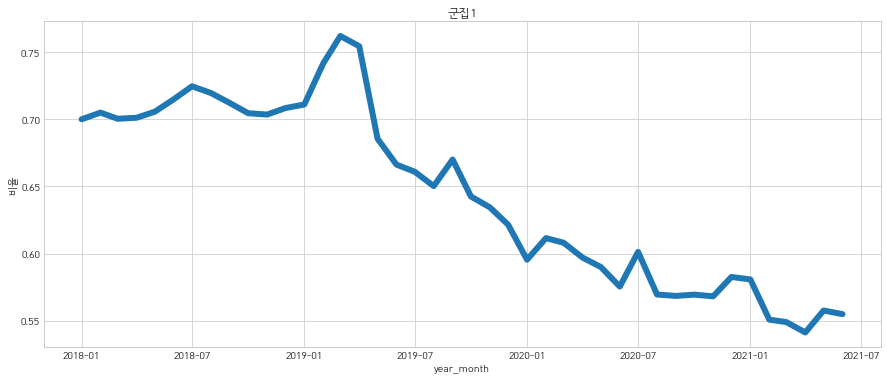

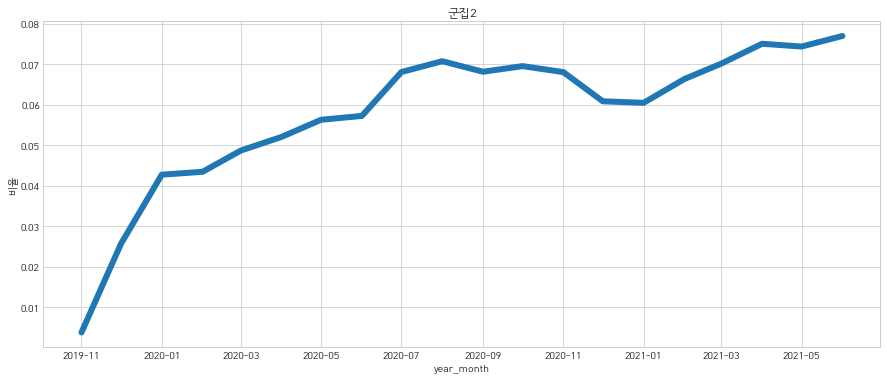

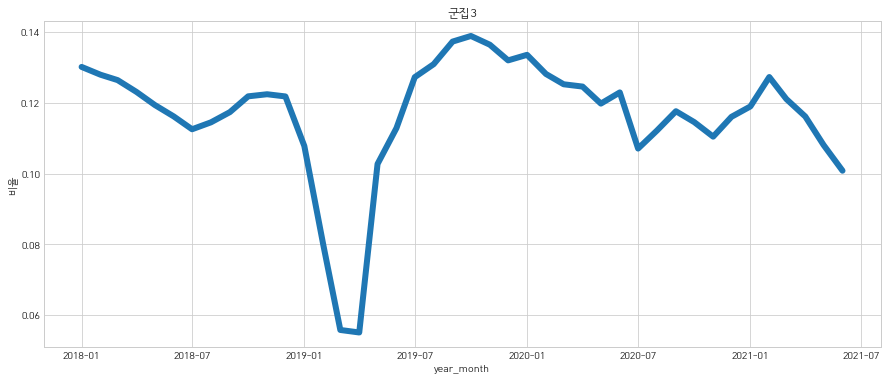

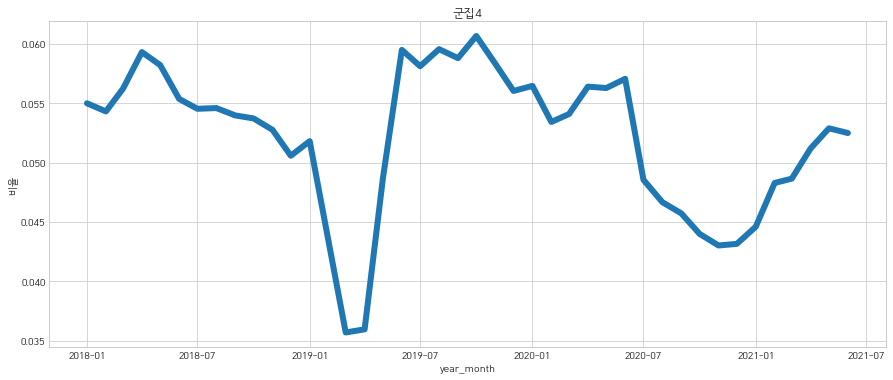

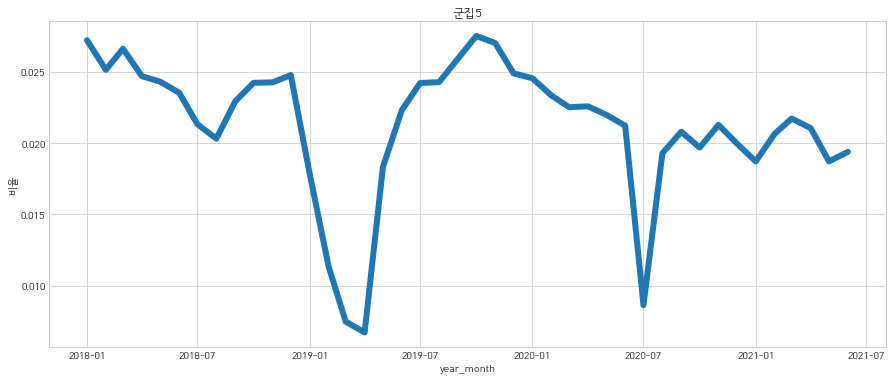

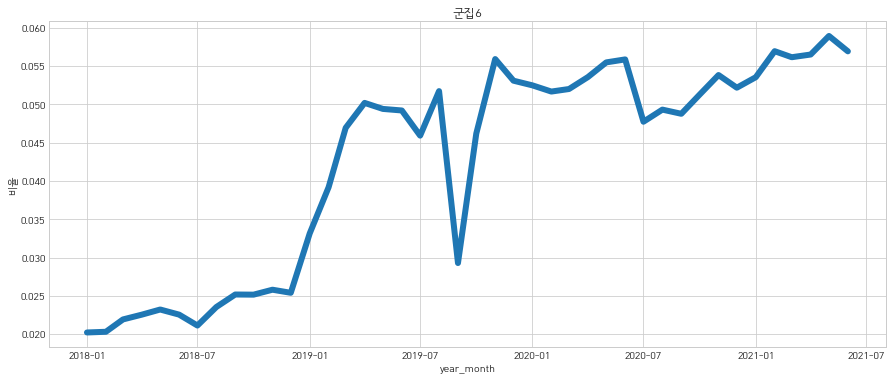

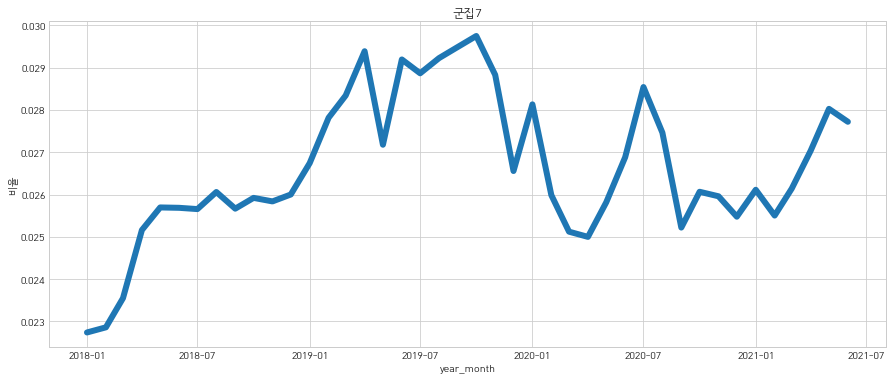

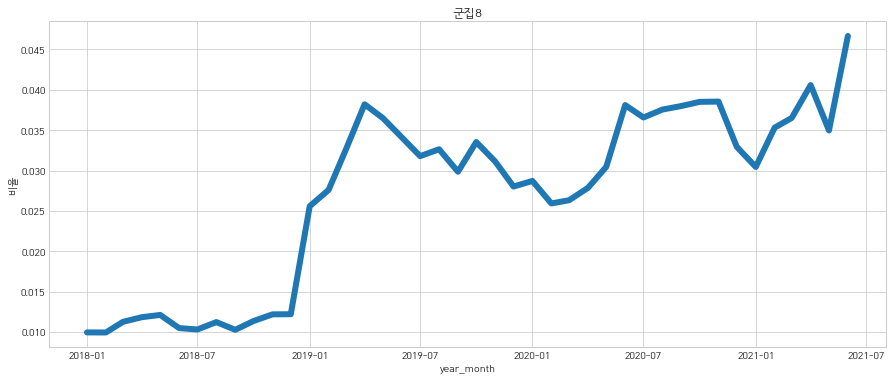

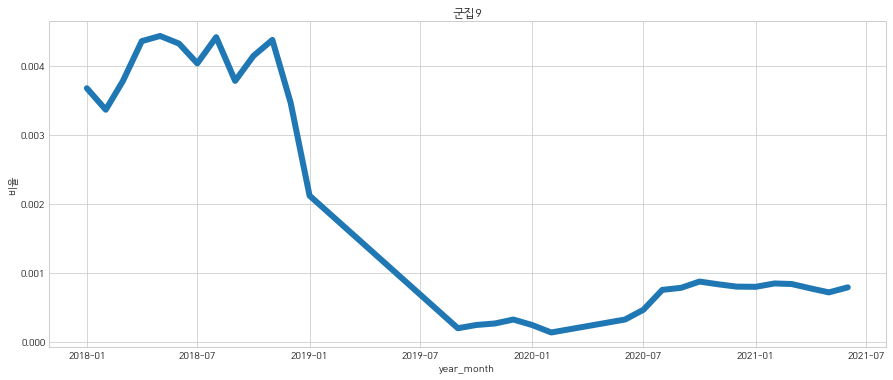

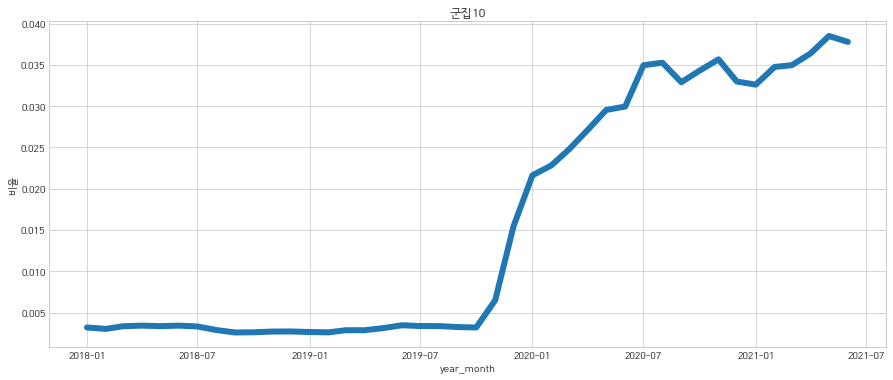

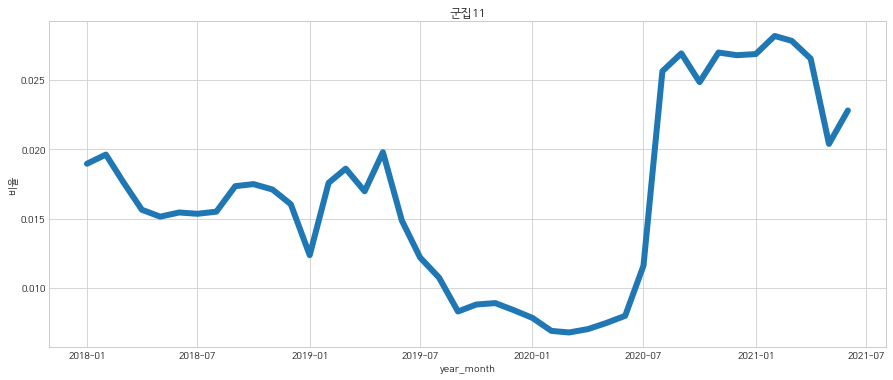

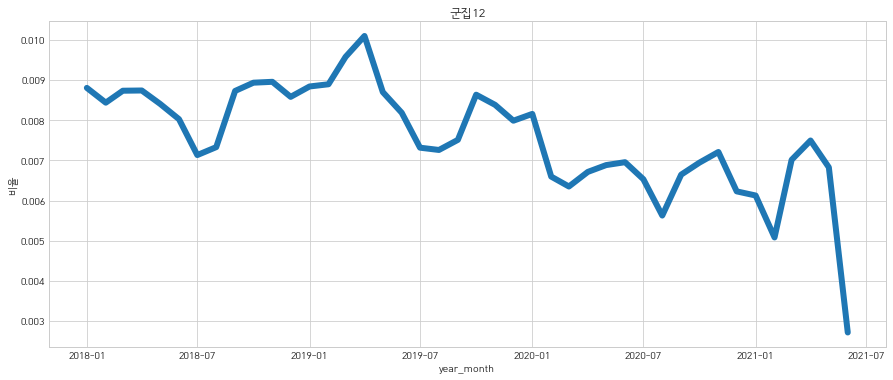

In [420]:
g1_error = finde_rolling(g1, g1_gg, '군집1', 1)
g2_error = finde_rolling(g2, g2_gg, '군집2', 2)
g3_error = finde_rolling(g3, g3_gg, '군집3', 3)
g4_error = finde_rolling(g4, g4_gg, '군집4', 4)
g5_error = finde_rolling(g5, g5_gg, '군집5', 5)
g6_error = finde_rolling(g6, g6_gg, '군집6', 6)
g7_error = finde_rolling(g7, g7_gg, '군집7', 7)
g8_error = finde_rolling(g8, g8_gg, '군집8', 8)
g9_error = finde_rolling(g9, g9_gg, '군집9', 9)
g10_error = finde_rolling(g10, g10_gg, '군집10', 10)
g11_error = finde_rolling(g11, g11_gg, '군집11', 11)
g12_error = finde_rolling(g12, g12_gg, '군집12', 12)

In [421]:
pred_df = pd.concat([g1_error, g2_error,g3_error, g4_error, g5_error, g6_error,g7_error,g8_error,g9_error, g10_error, g11_error,g12_error], axis=0).reset_index(drop=True).round()

In [422]:
pred_df

,행정동명,pred_7,pred_8
0,건입동,37972809.0,38771097.0
1,노형동,248761583.0,253991200.0
2,삼도1동,61623287.0,62918769.0
3,삼도2동,25042203.0,25568655.0
4,삼양동,100071520.0,102175285.0
5,아라동,116739233.0,119193396.0
6,연동,197112577.0,201256397.0
7,오라동,60546326.0,61819168.0
8,외도동,104155023.0,106344633.0
9,용담1동,35059344.0,35796383.0


## 몇몇 행정동 단변량 예측값으로 대체

In [423]:
## 예측
dong_list = ["효돈동", "한림읍", '중앙동', "중문동", 
'정방동', '일도1동', '이도2동', '이도1동', '오라동', '연동',
'삼양동', '삼도1동', '봉개동', '대천동', '건입동']

window_size=30
except_group = []
for t,dong_name in zip(range(1,len(dong_list)+1), dong_list):
    except_dong = food_waste[food_waste.행정동명.isin([dong_name])].groupby(['date'])['배출량'].sum().reset_index(drop=True)
    train_feature, train_label = make_dataset(except_dong,window_size=window_size)

    ## target
    train_x=train_feature.reshape(-1,window_size)
    print(train_x.shape)
    train_y=train_label
    print(train_y.shape)

    ## modeling
    rf=RandomForestRegressor(random_state=2021,
                            n_estimators=5000)
    rf.fit(train_x,train_y)
    print(train_x)
    ## 예측
    pred=np.array([])
    j=0
    for i in tqdm(range(0,62)):
        if i==0:
            test_x = np.array(except_dong[-30:]).reshape(1,30)
            pred = np.append(pred, rf.predict(test_x))
        elif i>0 and i<=29:
            test_x = np.array(except_dong[-30+i:]).reshape(1,-1)
            test_x = np.append(test_x, pred).reshape(1,30)
            pred = np.append(pred, rf.predict(test_x))
        else:
            test_x = pred[j:i].reshape(-1,30)
            pred = np.append(pred, rf.predict(test_x))
            j+=1
    except_group.append(pred)
    print(pred)
    print()
    print('cluster',t)
    print('#############################################################################')

(1246, 30)
(1246,)
[[444650 822950 577200 ... 597150 668150 661900]
 [822950 577200 584850 ... 668150 661900 588850]
 [577200 584850 669700 ... 661900 588850 818550]
 ...
 [309500 397600 411000 ... 941350 853350 992150]
 [397600 411000 729200 ... 853350 992150 956900]
 [411000 729200 843400 ... 992150 956900 900500]]


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.67it/s]


[892282.7  928405.6  889816.55 891940.9  911806.26 873089.71 855427.68
 925745.61 878896.44 906956.39 882788.68 916045.13 891551.49 877069.78
 883160.27 874978.63 867171.71 870479.88 858304.11 860353.37 873001.46
 875114.53 873580.99 869468.11 868503.48 870588.47 866825.46 865832.25
 869688.35 868998.73 857284.88 865391.48 863282.46 866693.72 868569.82
 871588.32 871422.28 863206.58 857921.51 866645.72 868585.07 874272.05
 866871.35 862268.95 862534.76 863349.78 864160.87 873307.36 869133.52
 863045.07 861519.63 863970.42 864624.43 866581.26 868843.94 866989.04
 864408.5  862953.49 861459.91 865954.74 873268.13 871032.46]

cluster 1
#############################################################################
(569, 30)
(569,)
[[      0       0    3300 ...  491050  459750  510150]
 [      0    3300    6450 ...  459750  510150  531100]
 [   3300    6450    5150 ...  510150  531100  619350]
 ...
 [2480200 2745150 2512950 ... 3423700 2885450 2241700]
 [2745150 2512950 2585650 ... 2885450 2

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.71it/s]


[2644351.294  2727538.3    2846413.946  2687367.938  2834236.198
 2596813.14   2788210.38   2709712.948  2762911.45   2644678.954
 1948731.286  2384626.918  2632524.342  1945860.936  2586372.522
 2394230.428  2454128.398  2336817.442  2311643.0348 2592478.116
 1912723.558  2485462.442  2307791.528  2379058.568  2542481.556
 2251095.376  2487754.7328 2152785.476  2333505.1424 2555351.378
 2306423.1048 2481331.586  2412395.214  2329477.768  2485198.924
 2312057.1304 2436127.886  2472104.8528 2306731.7028 2458700.402
 2324164.718  2403347.638  2360174.98   2294508.21   2454040.104
 2333309.57   2402827.392  2353465.236  2289379.74   2415911.236
 2328253.93   2405527.094  2339193.87   2299374.38   2419294.916
 2316244.63   2401687.646  2329649.9    2288221.55   2418030.424
 2299816.78   2392847.444 ]

cluster 2
#############################################################################
(1246, 30)
(1246,)
[[1384300 1794650 1799100 ... 1610550 1592150 1575450]
 [1794650 1799100 1611050 ...

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.70it/s]


[1334488.24 1325878.03 1379834.76 1324106.6  1353378.55 1348483.23
 1381954.48 1347331.33 1354199.77 1375262.   1342561.72 1344203.74
 1340910.61 1358677.56 1334872.98 1339133.37 1384715.97 1364661.87
 1348386.25 1354748.04 1370877.46 1361985.4  1350880.25 1346674.98
 1357763.43 1361647.35 1350941.05 1362735.66 1345797.4  1341015.12
 1356263.89 1355821.57 1355462.4  1354357.79 1359990.9  1354642.58
 1341790.85 1353780.29 1354236.02 1354903.18 1343184.78 1350646.93
 1352370.45 1353065.33 1353628.22 1348830.81 1349886.91 1350178.69
 1354676.83 1353907.45 1348761.18 1350257.25 1352581.78 1353723.93
 1348421.62 1350558.58 1350629.86 1352445.06 1351546.63 1351242.27
 1351551.68 1351479.24]

cluster 3
#############################################################################
(1246, 30)
(1246,)
[[1699100 1847400 1577550 ... 1806300 1594000 1503350]
 [1847400 1577550 1699900 ... 1594000 1503350 1576200]
 [1577550 1699900 1744100 ... 1503350 1576200 1784950]
 ...
 [2134500 2325700 2188250 ..

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.68it/s]


[2228749.5228 2276901.3678 2343048.905  2328832.9626 2266544.1956
 2206223.1662 2223805.3506 2193798.227  2223639.9328 2283471.6986
 2270493.3728 2244078.882  2210646.0944 2192126.999  2143223.0658
 2189884.7598 2225582.365  2242901.6522 2209166.7052 2174565.1838
 2193723.9988 2191849.4726 2219286.5722 2232544.825  2229059.4802
 2231295.3538 2207356.0604 2206629.9282 2188402.726  2217052.563
 2216257.8784 2224199.59   2207178.2738 2185641.1084 2204343.952
 2186631.0572 2199534.2904 2200950.916  2198867.6142 2204251.7292
 2181555.811  2198699.9616 2193990.8476 2196846.0952 2197734.5016
 2192769.508  2199213.1186 2191226.0202 2198645.3722 2191533.0506
 2196452.358  2197971.7294 2196666.6312 2197580.045  2188431.9172
 2197517.6628 2191530.0222 2199701.059  2197366.5848 2195329.2356
 2199222.6752 2189270.562 ]

cluster 4
#############################################################################
(1246, 30)
(1246,)
[[1025900  967650  921250 ...  748600  836250  838750]
 [ 967650  921250  

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.70it/s]


[852092.68 891309.23 853709.12 852303.99 861780.   839652.99 875663.21
 845515.07 878459.84 847170.24 856908.08 846106.1  851244.09 876212.06
 848167.65 879246.65 857454.55 848405.26 861438.49 832737.99 880160.18
 850623.85 868870.86 853487.66 835353.14 850158.21 853106.24 870267.72
 852896.98 862079.79 852361.78 850023.86 857344.18 845252.93 864030.94
 852304.57 852438.82 851247.75 844045.34 852744.72 852042.81 853622.21
 851798.76 851519.19 851369.57 848040.67 850025.71 848852.14 849585.08
 849745.62 847649.71 849469.08 847133.9  847944.61 848911.81 850389.82
 849693.68 848901.45 850034.43 849233.   849012.14 849425.91]

cluster 5
#############################################################################
(1234, 30)
(1234,)
[[718950 678450 657850 ... 723750 687650 731700]
 [678450 657850 693850 ... 687650 731700 610550]
 [657850 693850 682950 ... 731700 610550 746400]
 ...
 [585150 677850 576100 ... 504950 150900  35700]
 [677850 576100 522800 ... 150900  35700  15650]
 [576100 522

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.73it/s]


[134374.75 148045.14 148967.52 126180.99 130978.91 154586.8  177840.69
 239458.75 294282.92 332172.83 342623.07 334568.69 353264.19 363177.84
 404988.14 403438.03 406129.75 419827.86 429912.39 410621.35 407616.86
 437642.12 453200.97 465929.49 475388.62 479004.78 490981.68 490443.04
 490974.66 492170.7  495936.4  498894.87 497453.23 497931.47 493524.43
 500911.05 500287.62 502506.7  503355.14 503767.16 500692.22 501803.56
 508941.56 503091.3  509042.5  510036.74 506368.07 503889.39 501535.43
 504790.83 504645.78 508440.69 507546.55 500152.38 497532.45 499185.93
 502744.75 499186.94 500053.88 501026.58 499422.95 498002.81]

cluster 6
#############################################################################
(1247, 30)
(1247,)
[[9033700 8945950 8485350 ... 8606550 7159850 7793850]
 [8945950 8485350 8135600 ... 7159850 7793850 7093900]
 [8485350 8135600 7402500 ... 7793850 7093900 8085500]
 ...
 [6946750 8604050 7365400 ... 7025950 7368150 8993950]
 [8604050 7365400 7298850 ... 7368150

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.69it/s]


[7379134.8864 7035655.1556 7636743.2868 8661017.5736 7842192.084
 7604096.0728 7308914.4528 7377715.3172 7034626.6024 7691551.1708
 8814133.21   7818188.66   7615620.06   7436501.0064 7423742.8884
 7041347.9444 7612896.596  8945431.2228 7940620.044  7736939.4528
 7386221.6424 7481038.7816 7102872.3436 7644875.972  9064605.5408
 7985186.724  7772673.9156 7409433.7636 7518238.118  7129956.046
 7731576.7676 9092004.5716 8033542.142  7793413.19   7444943.37
 7529391.0556 7156123.5992 7752893.918  9117899.4072 8052770.228
 7786188.5028 7478787.3576 7542707.3804 7190754.9768 7744119.0248
 9133461.0692 8057575.934  7801601.2108 7503260.2632 7567821.0972
 7221091.85   7758979.3936 9161038.7504 8066328.098  7842652.4636
 7520700.5676 7575039.74   7267445.7936 7765173.2292 9224318.2876
 8090382.012  7871537.1976]

cluster 7
#############################################################################
(1247, 30)
(1247,)
[[1582300 1952450 1706900 ... 1618700 1683450 1583200]
 [1952450 1706900 1650

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.74it/s]


[ 235983.45  213534.27  226671.44  248497.92  340870.68  344506.49
  412266.58  512173.52  574375.25  587505.42  669166.98  742267.41
  832468.95 1030110.62  941941.81  914744.39  933133.93  914604.25
  908772.67  901813.85  900580.41  910838.3   879189.89  885938.61
  905728.61  962515.57  969462.83  960063.83  949388.03  944301.5
  935608.7   934340.36  934001.9   952426.72  966859.62  949776.58
  946341.8   951510.28  947360.43  937329.64  941403.93  963085.45
  966033.99  940111.59  939426.62  959363.87  956576.34  955664.3
  954792.98  971536.76  974071.79  949283.68  941126.09  963450.86
  960936.97  958914.97  958187.01  967556.74  971339.38  947576.92
  941603.06  966055.99]

cluster 8
#############################################################################
(1247, 30)
(1247,)
[[2128300 2175450 1680400 ... 1933600 1649350 1723300]
 [2175450 1680400 1782850 ... 1649350 1723300 1652850]
 [1680400 1782850 1652350 ... 1723300 1652850 1684650]
 ...
 [1855650 2386950 1936300 ... 

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.69it/s]


[1898914.4298 1781246.7594 1859419.0776 2312211.1    2081263.2896
 1904348.6292 1851549.14   1901369.85   1794731.3394 1846768.8916
 2252107.34   2061934.0198 1915293.11   1865722.6    1888584.31
 1778340.0996 1821528.6472 2276889.29   2068365.84   1911000.2798
 1847755.04   1873782.5096 1765938.3396 1820713.4378 2297402.58
 2069251.41   1903993.22   1861381.42   1876531.9896 1752756.6798
 1818919.325  2291116.75   2068837.72   1893779.2    1856532.96
 1870554.6596 1738048.7198 1820021.4456 2297015.63   2067240.2
 1890476.27   1851751.74   1872660.7796 1731328.1496 1813498.4248
 2296144.73   2060022.31   1887661.0398 1855849.35   1869405.3294
 1717770.2796 1826554.0856 2296762.25   2057361.15   1890755.4198
 1856549.02   1870369.6896 1725844.4296 1816928.2444 2300616.91
 2056901.71   1890437.5098]

cluster 9
#############################################################################
(1247, 30)
(1247,)
[[7264350 7546850 6893050 ... 7026600 6214000 6601200]
 [7546850 6893050 7042850 ..

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.68it/s]


[6160492.11   5850101.352  6312661.77   6978590.38   6538881.27
 6246794.702  6102244.414  6258384.06   6097330.886  6266676.544
 7135793.85   6566829.63   6280530.352  6279705.06   6233707.73
 6030773.842  6245143.57   7178242.41   6519379.45   6376538.512
 6327528.462  6254849.752  6073081.138  6263529.844  7274838.05
 6612735.66   6395583.154  6356468.014  6276216.41   6141726.968
 6285164.76   7332425.14   6616043.53   6475302.302  6384234.22
 6324398.4    6177195.464  6308743.26   7432553.33   6655682.44
 6520555.3    6455049.13   6367891.23   6170985.764  6335190.12
 7491259.09   6682106.27   6559374.312  6472910.54   6378276.762
 6188881.044  6341200.32   7468690.96   6732715.9    6569303.65
 6474946.97   6425679.01   6220025.418  6365269.08   7540028.1622
 6757923.56   6575559.3   ]

cluster 10
#############################################################################
(1247, 30)
(1247,)
[[3997300 3620400 3139900 ... 3727050 3213600 3297750]
 [3620400 3139900 3607550 ... 3213

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.69it/s]


[3145684.556 2968103.51  3145888.672 3830720.34  3413677.206 3183945.914
 3156317.497 3170077.22  2975016.922 3201603.783 3888388.984 3380284.067
 3191276.65  3148678.887 3131230.764 2993764.247 3083417.121 3827614.52
 3381386.475 3224982.33  3158535.77  3112180.93  2963052.044 3080702.496
 3792298.846 3397090.787 3210578.4   3126599.94  3108160.79  2967708.1
 3054804.664 3826792.726 3368937.615 3203986.907 3121902.41  3108686.95
 2957168.794 3049965.564 3797148.914 3372010.465 3194290.707 3119887.63
 3104011.17  2950929.864 3039587.25  3796937.94  3368542.469 3199261.991
 3116583.39  3095891.19  2952383.484 3037187.33  3787980.676 3371238.451
 3182431.601 3115481.592 3102005.5   2949484.844 3045319.34  3796451.666
 3370367.353 3179136.571]

cluster 11
#############################################################################
(1247, 30)
(1247,)
[[2556750 2724050 2333350 ... 2414350 2049850 2276400]
 [2724050 2333350 2503300 ... 2049850 2276400 2137850]
 [2333350 2503300 2238050 ... 

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.71it/s]


[2033746.005 1913577.65  2075420.982 2170592.857 1991595.51  1982847.431
 1982223.07  2051701.63  1933395.36  2065479.72  2159160.04  2009344.623
 1983991.341 1935576.28  2081524.544 1944271.3   2101613.75  2166754.415
 2034768.22  2021160.5   2032598.02  2083364.175 1959899.86  2119696.132
 2171047.3   2062798.72  2050377.44  2037534.54  2114161.47  1990369.46
 2131103.24  2192998.91  2109364.65  2080028.49  2094447.764 2121510.622
 2030682.48  2145800.63  2216795.59  2147240.471 2106347.57  2108956.01
 2134379.02  2081032.53  2162533.98  2255868.23  2174666.92  2119890.9
 2119999.85  2148482.981 2121131.74  2171534.89  2251851.7   2200946.11
 2136546.74  2128070.12  2158709.14  2124315.33  2171051.67  2248431.3
 2212160.33  2173169.66 ]

cluster 12
#############################################################################
(1247, 30)
(1247,)
[[395300 356300 300400 ... 393950 287100 277150]
 [356300 300400 483350 ... 287100 277150 347800]
 [300400 483350 265300 ... 277150 347800 348

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.69it/s]


[500685.0018 506440.4194 516666.9198 620288.85   587092.36   518067.1694
 500217.2096 506113.9422 494862.5292 509428.0194 607651.07   567201.07
 513419.638  500594.2772 494732.1218 486916.8852 499622.0576 570356.8
 577864.96   519746.0592 503721.5976 500645.9688 494181.0208 495776.999
 587150.13   567604.71   513071.5786 497151.3482 495329.0974 491181.559
 489092.4796 596680.85   549425.82   505585.9794 496531.3268 495133.9634
 490204.3292 484185.7698 560340.52   552563.84   506822.539  490557.5482
 492293.9262 491137.5794 483470.1198 557908.91   548565.47   505228.229
 490370.498  492638.1276 489442.9286 480397.4696 571083.98   549701.84
 502701.7392 489397.7386 494044.7764 488694.3188 485196.2494 552668.95
 542882.32   501891.9488]

cluster 13
#############################################################################
(1246, 30)
(1246,)
[[1765600 2148050 2061650 ... 1628650 1619100 1524200]
 [2148050 2061650 1735000 ... 1619100 1524200 1490150]
 [2061650 1735000 1978850 ... 1524200

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.70it/s]


[1854990.209  1881569.485  1869164.8798 2071318.4398 1982993.538
 1853613.3806 1903978.4066 1869518.6022 1836221.77   1895164.171
 2036025.9296 1975071.8588 1867799.8814 1869520.6756 1888198.6764
 1867157.9212 1877445.9582 2019730.0706 1945489.8718 1891191.3182
 1885973.5802 1889562.7502 1866216.5904 1879103.007  2002471.677
 1969379.7062 1893378.2976 1896870.5704 1876630.8196 1873490.3338
 1899850.01   2004361.9652 1952902.4672 1892975.7196 1882317.1768
 1891692.7964 1871491.2916 1895808.4186 1997767.9294 1955012.6312
 1900594.3424 1883045.9404 1890240.1654 1889003.2862 1908814.2248
 1993894.8302 1955133.2118 1909817.7824 1893162.0436 1888101.0378
 1889913.8538 1940558.138  1992562.8906 1953400.5254 1910397.835
 1889697.3128 1897535.4716 1893001.7114 1950741.4562 1991255.9172
 1953586.5132 1919010.0864]

cluster 14
#############################################################################
(1246, 30)
(1246,)
[[1708250 1841150 1411450 ... 1454700 1230650 1397550]
 [1841150 1411450 15

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.68it/s]

[1169511.39 1199025.74 1335503.85 1283426.94 1242503.55 1195510.4
 1186551.95 1138881.53 1185158.35 1360898.27 1311046.11 1250487.24
 1203419.73 1201301.92 1155294.45 1210416.67 1312354.43 1297731.86
 1242303.77 1207970.41 1168462.05 1173929.62 1182977.45 1335502.44
 1276612.97 1215428.79 1209815.28 1198223.8  1167591.57 1210634.38
 1281533.17 1254833.2  1209356.33 1199760.11 1198886.   1155418.88
 1206123.8  1301282.25 1230796.58 1206255.49 1200266.01 1190362.46
 1172656.   1212060.49 1257609.1  1223186.48 1199892.81 1196898.5
 1187590.   1171738.2  1191332.66 1232147.17 1209350.25 1196708.77
 1195686.09 1178476.19 1168062.08 1187366.18 1206471.22 1210394.87
 1190160.32 1183074.85]

cluster 15
#############################################################################


In [424]:
## 단일 예측 행정동 데이터프레임화
seven = []
eight = []

for i in range(len(except_group)):
    seven.append(np.sum(except_group[i][:31]))
    eight.append(np.sum(except_group[i][31:]))
    

In [425]:
pred_df2 = pd.DataFrame({'행정동명':dong_list, 'pred_7':seven, 'pred_8':eight})

In [426]:
pred_final = pd.concat([pred_df[~pred_df.행정동명.isin(dong_list)].reset_index(drop=True), pred_df2], axis=0).sort_values(by='행정동명').reset_index(drop=True).round(1)
pred_final

,행정동명,pred_7,pred_8
0,건입동,38110010.1,37324203.3
1,구좌읍,40066533.0,40194228.0
2,남원읍,72372733.0,74024075.0
3,노형동,248761583.0,253991200.0
4,대륜동,48135919.0,46903910.0
5,대정읍,113418310.0,114919763.0
6,대천동,59189092.4,59637799.0
7,도두동,22377770.0,22910156.0
8,동홍동,99512170.0,101782757.0
9,봉개동,16232873.8,15937749.6


In [427]:
pred_final.to_csv('data/final.csv', encoding='euc-kr',index=False)